<a href="https://colab.research.google.com/github/Zunuoh/Dengue-Fever-Prediction/blob/main/New_Dengue_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
import sklearn as sk
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer, root_mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from prophet import Prophet
import logging
import folium
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [2]:
df = pd.read_csv('climate_disease_dataset.csv')
df.head()

year  month                country   region  avg_temp_c  precipitation_mm  \
0  2000      1  Palestinian Territory  Central   28.132468        152.083870   
1  2000      2  Palestinian Territory  Central   30.886500        119.591418   
2  2000      3  Palestinian Territory  Central   31.366433         95.876124   
3  2000      4  Palestinian Territory  Central   28.481870        175.315731   
4  2000      5  Palestinian Territory  Central   26.890370        191.445990   

   air_quality_index   uv_index  malaria_cases  dengue_cases  \
0         110.487231  12.000000             53           145   
1          83.467928  12.000000            132            48   
2          93.095292  12.000000             34            80   
3         105.530192   9.395894             23           133   
4          60.205979   9.935726             39            74   

   population_density  healthcare_budget  
0                 113               1068  
1                 113               1068  
2                 113               1068  
3                 113               1068  
4                 113               1068

In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df.describe().transpose()

count     mean      std      min      25%      50%  \
year               34560.000 2011.500    6.922 2000.000 2005.750 2011.500   
month              34560.000    6.500    3.452    1.000    3.750    6.500   
avg_temp_c         34560.000   20.395    8.411   -2.557   14.404   20.352   
precipitation_mm   34560.000  192.668   90.504    0.000  124.641  195.315   
air_quality_index  34560.000   43.788   33.080    0.000   15.323   40.686   
uv_index           34560.000   10.211    1.937    0.871    8.921   10.761   
malaria_cases      34560.000   70.520   46.131    0.000   32.000   69.000   
dengue_cases       34560.000   75.941   37.324    0.000   48.000   76.000   
population_density 34560.000  266.900  136.001   50.000  136.250  277.500   
healthcare_budget  34560.000 2764.650 1418.119  205.000 1435.500 2859.000   

                        75%      max  
year               2017.250 2023.000  
month                 9.250   12.000  
avg_temp_c           26.343   44.584  
precipitation_mm    260.148  485.704  
air_quality_index    68.402  168.848  
uv_index             12.000   12.000  
malaria_cases       107.000  201.000  
dengue_cases        104.000  181.000  
population_density  384.750  498.000  
healthcare_budget  3996.750 4969.000

In [4]:
df.isnull().sum()

year                  0
month                 0
country               0
region                0
avg_temp_c            0
precipitation_mm      0
air_quality_index     0
uv_index              0
malaria_cases         0
dengue_cases          0
population_density    0
healthcare_budget     0
dtype: int64

In [5]:
print(len(df))

34560


In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34560 entries, 0 to 34559
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                34560 non-null  int64  
 1   month               34560 non-null  int64  
 2   country             34560 non-null  object 
 3   region              34560 non-null  object 
 4   avg_temp_c          34560 non-null  float64
 5   precipitation_mm    34560 non-null  float64
 6   air_quality_index   34560 non-null  float64
 7   uv_index            34560 non-null  float64
 8   malaria_cases       34560 non-null  int64  
 9   dengue_cases        34560 non-null  int64  
 10  population_density  34560 non-null  int64  
 11  healthcare_budget   34560 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 3.2+ MB


In [8]:
df['country'] = df['country'].astype('category')
df['region'] = df['region'].astype('category')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34560 entries, 0 to 34559
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   year                34560 non-null  int64   
 1   month               34560 non-null  int64   
 2   country             34560 non-null  category
 3   region              34560 non-null  category
 4   avg_temp_c          34560 non-null  float64 
 5   precipitation_mm    34560 non-null  float64 
 6   air_quality_index   34560 non-null  float64 
 7   uv_index            34560 non-null  float64 
 8   malaria_cases       34560 non-null  int64   
 9   dengue_cases        34560 non-null  int64   
 10  population_density  34560 non-null  int64   
 11  healthcare_budget   34560 non-null  int64   
dtypes: category(2), float64(4), int64(6)
memory usage: 2.7 MB


In [10]:
region_dummies = pd.get_dummies(df['region'], prefix="region")
country_dummies = pd.get_dummies(df['country'], prefix='country')

df = pd.concat([df, region_dummies, country_dummies], axis=1)

In [11]:
country_columns = [col for col in df.columns if col.startswith('country_')]
country_cases = df[country_columns].multiply(df['dengue_cases'], axis=0).sum()
country_cases = country_cases.reset_index()
country_cases.columns = ['Country', 'Total Cases']


region_columns = [col for col in df.columns if col.startswith('region_')]
region_cases = df[region_columns].multiply(df['dengue_cases'], axis=0).sum()
region_cases = region_cases.reset_index()
region_cases.columns = ['Region', 'Total Cases']

In [12]:
print(country_columns)
print(region_columns)

['country_American Samoa', 'country_Antarctica (the territory South of 60 deg S)', 'country_Antigua and Barbuda', 'country_Armenia', 'country_Aruba', 'country_Azerbaijan', 'country_Bahamas', 'country_Bangladesh', 'country_Barbados', 'country_Belgium', 'country_Brazil', 'country_Bulgaria', 'country_Burkina Faso', 'country_Cambodia', 'country_Chad', 'country_Chile', 'country_Christmas Island', 'country_Cocos (Keeling) Islands', 'country_Colombia', 'country_Congo', 'country_Cuba', 'country_Cyprus', 'country_Czech Republic', 'country_Denmark', 'country_Djibouti', 'country_Dominica', 'country_Dominican Republic', 'country_Ecuador', 'country_Egypt', 'country_El Salvador', 'country_Estonia', 'country_Ethiopia', 'country_Falkland Islands (Malvinas)', 'country_Fiji', 'country_Finland', 'country_French Guiana', 'country_French Polynesia', 'country_Gabon', 'country_Germany', 'country_Greenland', 'country_Grenada', 'country_Guadeloupe', 'country_Guam', 'country_Guinea-Bissau', 'country_Guyana', 'c

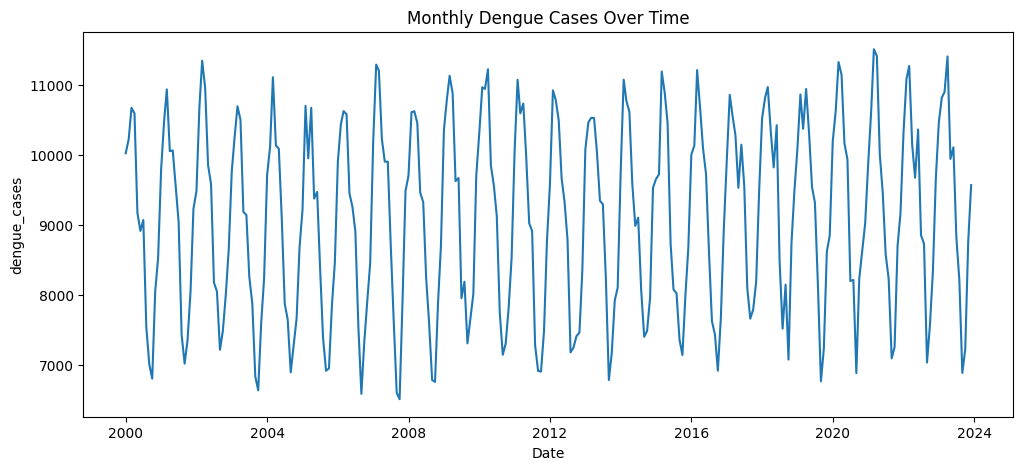

In [13]:
monthly = df.groupby(['year', 'month'])['dengue_cases'].sum().reset_index()
monthly['Date'] = pd.to_datetime(monthly[['year', 'month']].assign(DAY=1))

plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly, x='Date', y='dengue_cases')
plt.title("Monthly Dengue Cases Over Time")
plt.show()

## **FEATURE ENGINEERING**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # ideal line
plt.xlabel("Actual Cases")
plt.ylabel("Predicted Cases")
plt.title("Actual vs Predicted Cases")
plt.grid(True)
plt.show()

NameError: name 'y_test' is not defined

<Figure size 800x600 with 0 Axes>

## **COMPARE REGION CASES TO FACTORS**

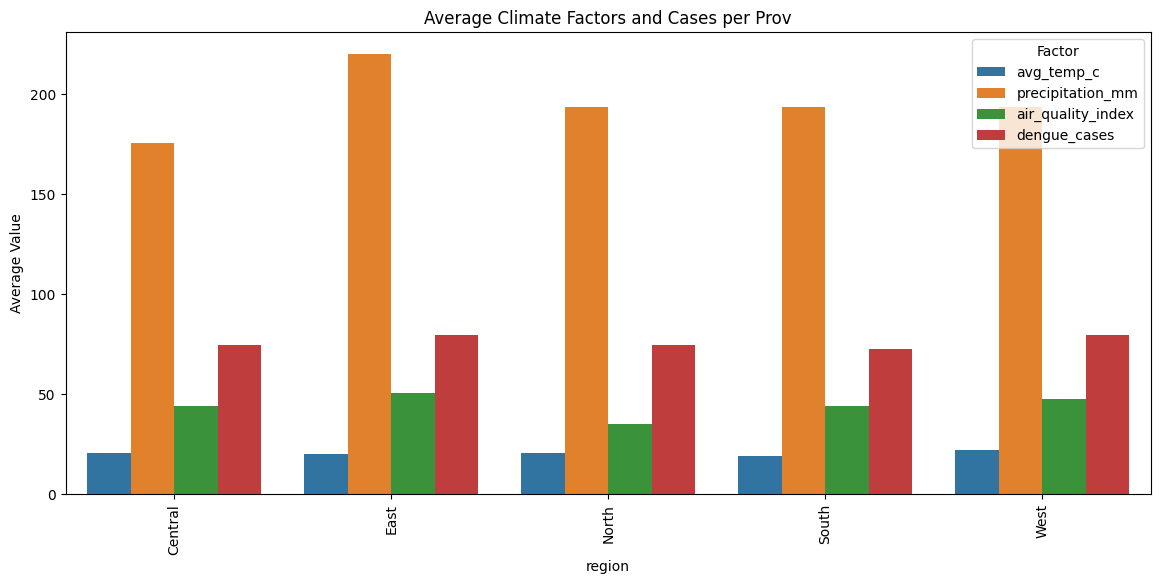

In [14]:
df['region'] = df[region_columns].idxmax(axis=1).str.replace('region_', '')
factors = df.groupby('region')[['avg_temp_c', 'precipitation_mm', 'air_quality_index', 'dengue_cases']].mean().reset_index()

# Plot side-by-side bars
factors_melted = factors.melt(id_vars='region', var_name='Factor', value_name='Average Value')

plt.figure(figsize=(14, 6))
sns.barplot(data=factors_melted, x='region', y='Average Value', hue='Factor', palette='tab10')
plt.title('Average Climate Factors and Cases per Prov')
plt.xticks(rotation=90)
plt.show()

In [ ]:
df['Prov'] = df[province_columns].idxmax(axis=1).str.replace('Province_', '')
factors = df.groupby('Prov')[['Temp_avg', 'Humidity_avg', 'Precipitation_avg', 'Longitude', 'Latitude', 'Cases']].mean().reset_index()

factors_melted = factors.melt(id_vars='Prov', var_name='Factor', value_name='Average Value')

plt.figure(figsize=(14, 6))
sns.barplot(data=factors_melted, x='Prov', y='Average Value', hue='Factor', palette='tab10')
plt.title('Average Climate Factors and Cases per Prov')
plt.xticks(rotation=90)
plt.show()

NameError: name 'province_columns' is not defined

### **COMPARE DISTRICT CASES TO FACTORS**

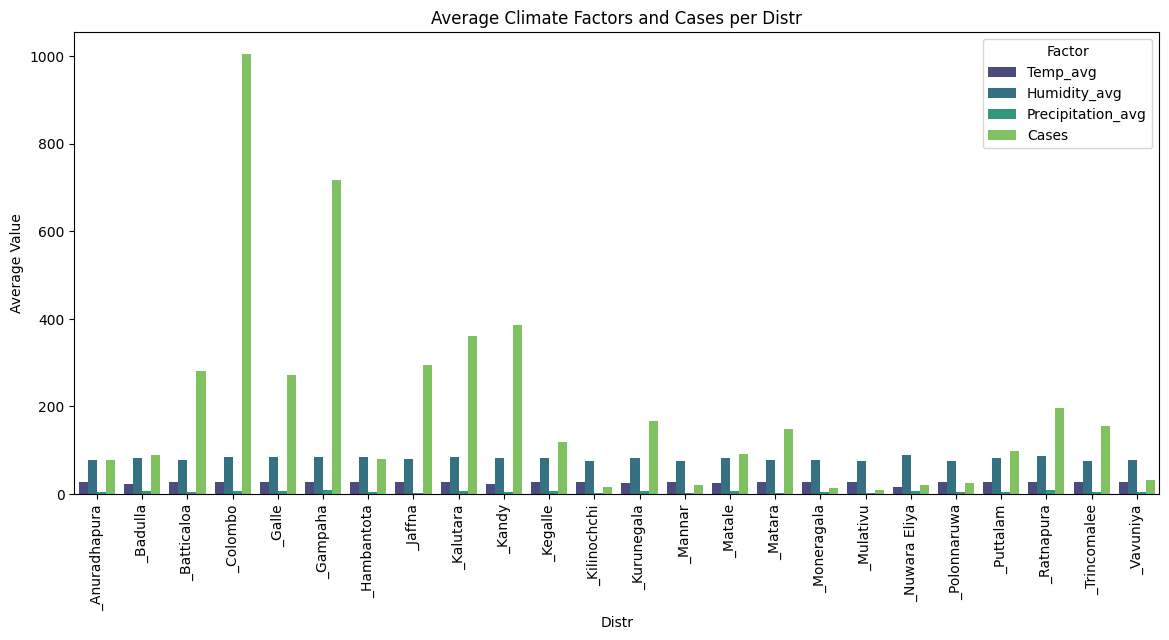

In [ ]:
df['Distr'] = df[district_columns].idxmax(axis=1).str.replace('District', '')
factors = df.groupby('Distr')[['Temp_avg', 'Humidity_avg', 'Precipitation_avg', 'Cases']].mean().reset_index()

# Plot side-by-side bars
factors_melted = factors.melt(id_vars='Distr', var_name='Factor', value_name='Average Value')

plt.figure(figsize=(14, 6))
sns.barplot(data=factors_melted, x='Distr', y='Average Value', hue='Factor', palette='viridis')
plt.title('Average Climate Factors and Cases per Distr')
plt.xticks(rotation=90)
plt.show()

### **CORRELATION HEATMAP**

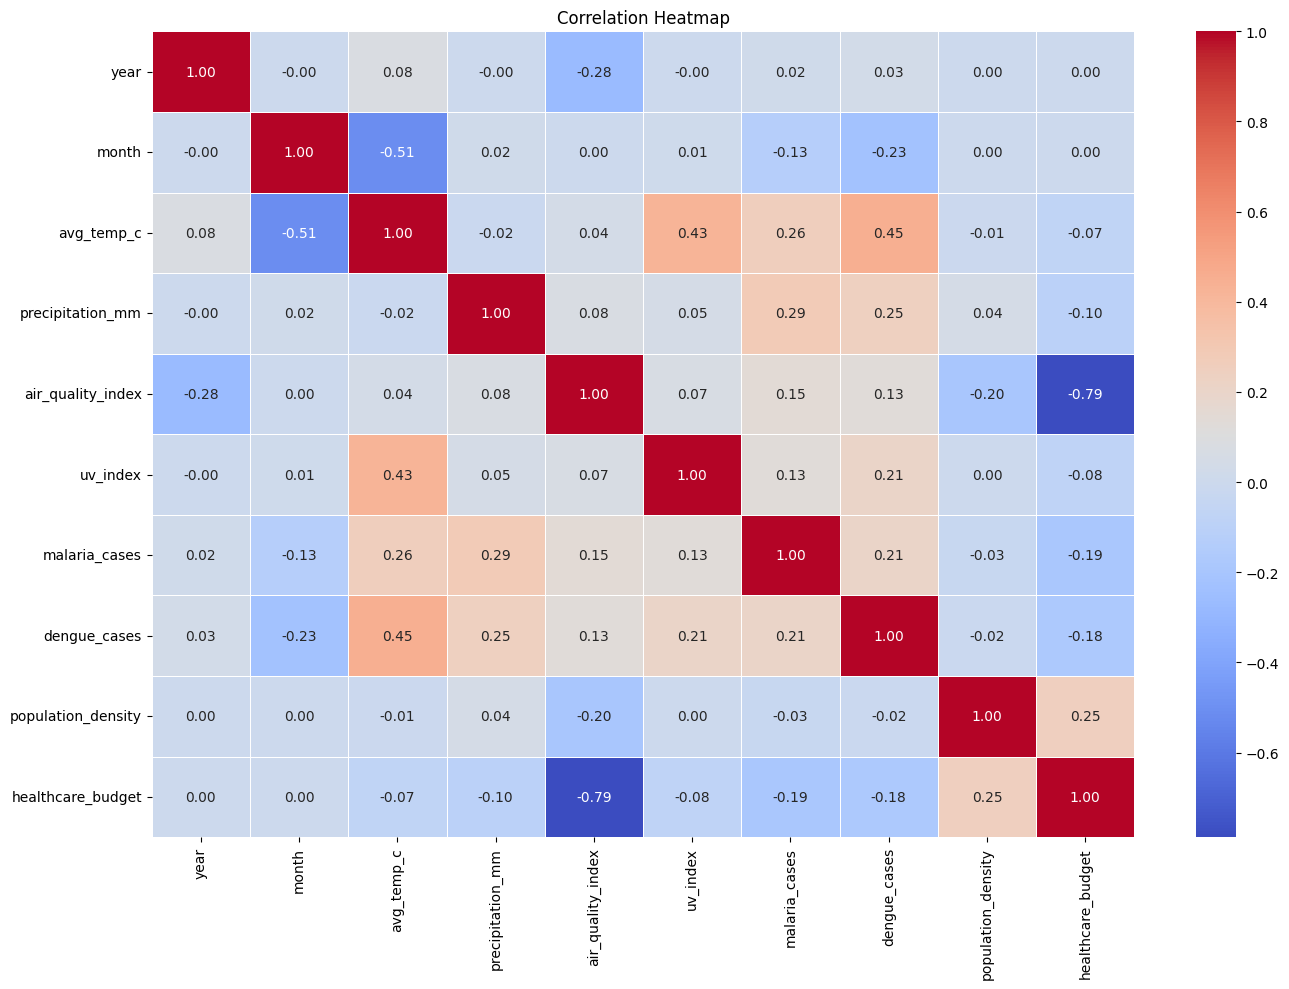

In [15]:
df_corr = df.copy()
df_corr = pd.get_dummies(df_corr, drop_first=True)
df_corr = df_corr.select_dtypes(include='number')  # Keep only numeric columns

# Compute correlation matrix
corr_matrix = df_corr.corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

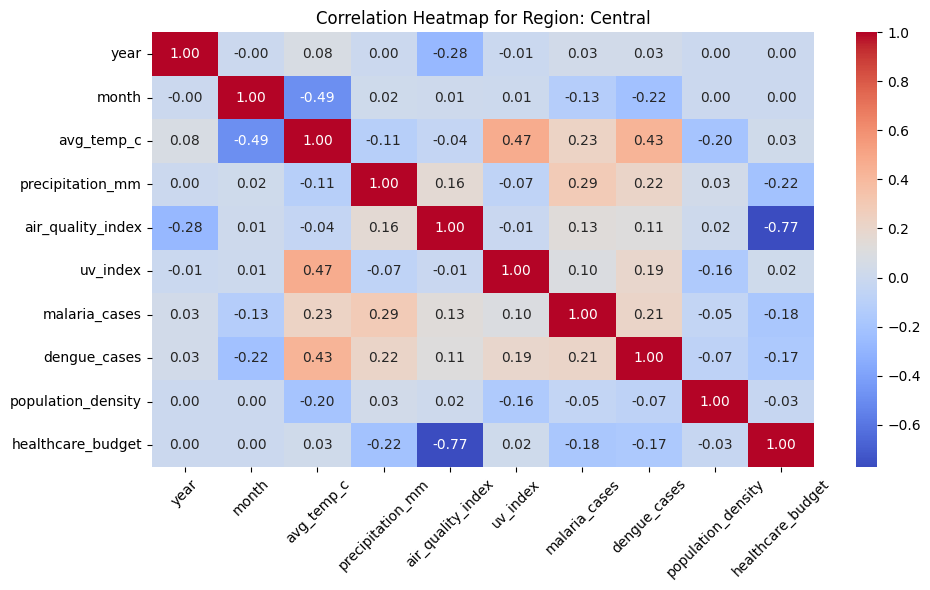

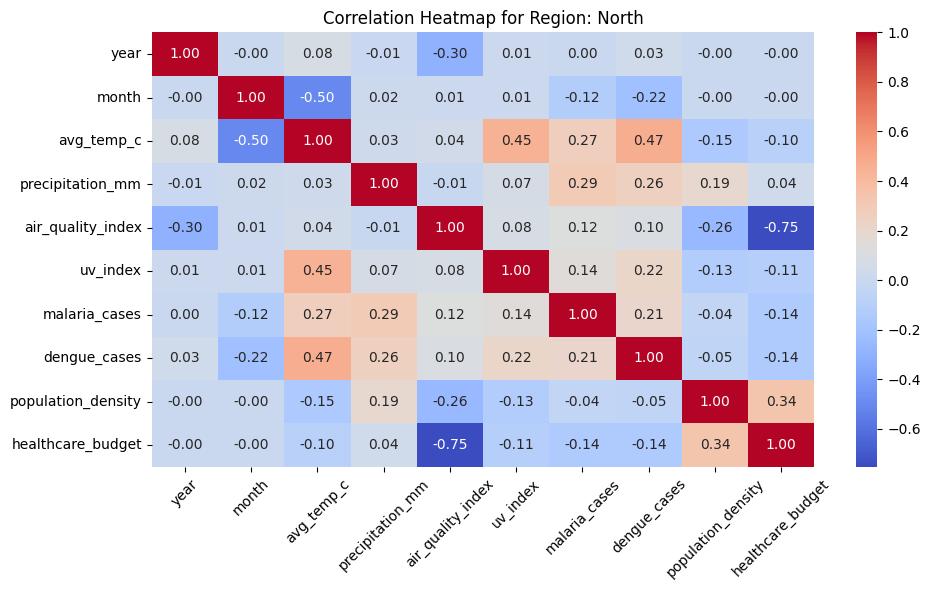

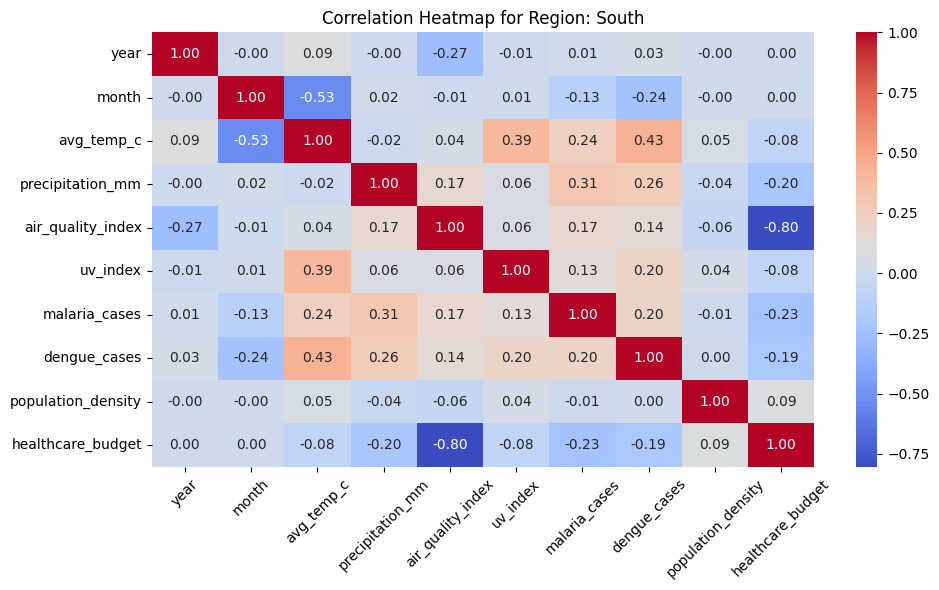

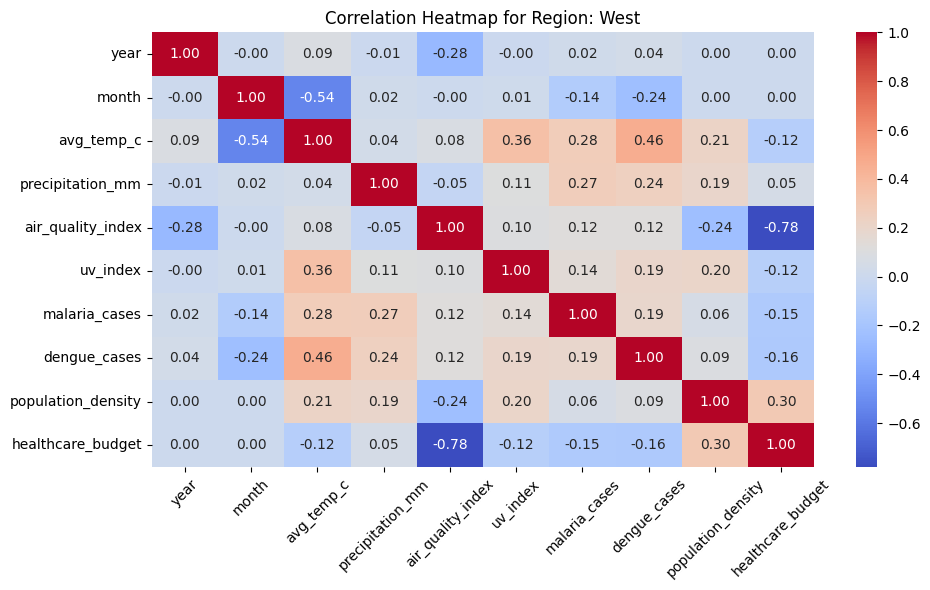

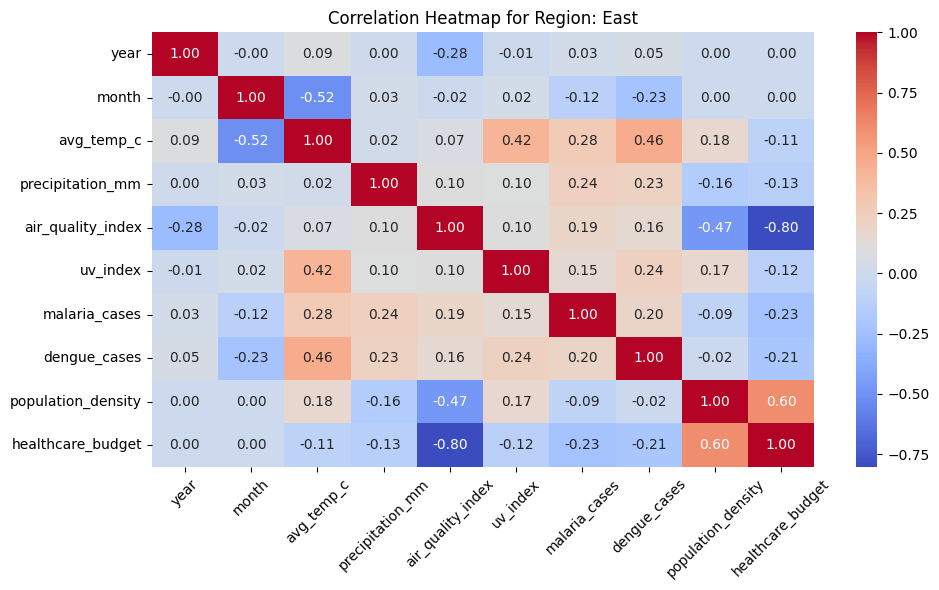

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure 'region' exists in your dataframe
if 'region' in df.columns:

    regions = df['region'].unique()

    for region in regions:
        region_df = df[df['region'] == region]

        # Optional: drop non-numeric columns
        numeric_cols = region_df.select_dtypes(include=['float64', 'int64'])

        # Compute correlation matrix
        corr_matrix = numeric_cols.corr()

        # Plot heatmap
        plt.figure(figsize=(10, 6))
        sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
        plt.title(f'Correlation Heatmap for Region: {region}')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

else:
    print("The column 'region' is not found in the dataframe.")

In [17]:
import pandas as pd
import statsmodels.api as sm

# 1. Select your predictor and target
X = df[['avg_temp_c']]  # Predictor: average temperature
y = df['dengue_cases']  # Target: dengue cases

# 2. Add a constant term for the intercept
X = sm.add_constant(X)

# 3. Fit the OLS (Ordinary Least Squares) model
model = sm.OLS(y, X).fit()

# 4. Print the summary for p-value, R-squared, etc.
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           dengue_cases   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     8837.
Date:                Sat, 23 Aug 2025   Prob (F-statistic):               0.00
Time:                        11:00:31   Log-Likelihood:            -1.7020e+05
No. Observations:               34560   AIC:                         3.404e+05
Df Residuals:                   34558   BIC:                         3.404e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.0995      0.470     74.687      0.0

Results above for p value is <0.05 so temperature is a factor

### **----------START MODELLING-----------**

### **FEATURE IMPORTANCE**


In [ ]:
X = df.drop(columns=["dengue_cases"])
Y = df["dengue_cases"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

importances = model.feature_importances_
features = X.columns

feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print(feature_importance_df)

NameError: name 'y' is not defined

### **RANDOM FOREST**

In [16]:
regions = [col for col in df.columns if col.startswith('region_')]

df['temp_precip_interaction'] = df['avg_temp_c'] * df['precipitation_mm']
df['air_quality_temp_interaction'] = df['air_quality_index'] * df['avg_temp_c']
df['uv_precip_interaction'] = df['uv_index'] * df['precipitation_mm']
df['env_stress_score'] = df['precipitation_mm'] * df['air_quality_index'] * df['uv_index']

features = [
    'avg_temp_c', 'precipitation_mm', 'air_quality_index',
    'malaria_cases', 'year', 'uv_index', 'population_density',
    'healthcare_budget', 'temp_precip_interaction',
    'air_quality_temp_interaction', 'uv_precip_interaction', 'env_stress_score', *regions
]

X = df[features]
y = df['dengue_cases']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

numeric_features = [
    'avg_temp_c', 'precipitation_mm', 'air_quality_index',
    'malaria_cases', 'year', 'uv_index', 'population_density',
    'healthcare_budget', 'temp_precip_interaction',
    'air_quality_temp_interaction', 'uv_precip_interaction', 'env_stress_score'
]

X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

R-squared: 0.25867224438937375
Mean Squared Error: 1060.6235897424767
Mean Absolute Error: 28.042640335648144
Root Mean Squared Error: 32.567216487481346


Sample y_test values: [ 79  72  92 115  65]
Sample y_pred values: [ 90.77  39.11  99.27 102.12  37.73]
MAE: 27.977103587962965


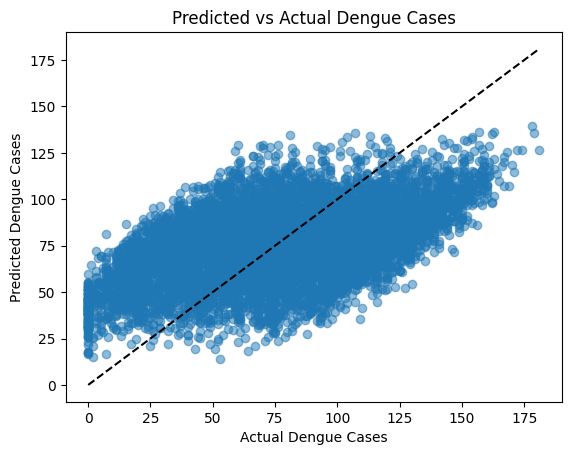

In [ ]:
print("Sample y_test values:", y_test[:5].values)
print("Sample y_pred values:", y_pred[:5])
print("MAE:", mean_absolute_error(y_test, y_pred))

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Dengue Cases")
plt.ylabel("Predicted Dengue Cases")
plt.title("Predicted vs Actual Dengue Cases")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.show()

### **LGBM**

In [17]:
regions = [ col for col in df.columns if col.startswith('region_')]
df['temp_precip_interaction'] = df['avg_temp_c'] * df['precipitation_mm']
df['air_quality_temp_interaction'] = df['air_quality_index'] * df['avg_temp_c']
df['uv_precip_interaction'] = df['uv_index'] * df['precipitation_mm']
df['env_stress_score'] = df['precipitation_mm'] * df['air_quality_index'] * df['uv_index']

features = ['avg_temp_c', 'precipitation_mm', 'air_quality_index',
            'malaria_cases', 'year', 'uv_index', 'population_density', 'healthcare_budget', 'temp_precip_interaction',
    'air_quality_temp_interaction', 'uv_precip_interaction', 'env_stress_score', *regions]

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

numeric_features = [
    'avg_temp_c', 'precipitation_mm', 'air_quality_index',
    'malaria_cases', 'year', 'uv_index', 'population_density',
    'healthcare_budget', 'temp_precip_interaction',
    'air_quality_temp_interaction', 'uv_precip_interaction', 'env_stress_score'
]

X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

# Step 6: Fit model
model = LGBMRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Step 7: Predict
y_pred = model.predict(X_test_scaled)

# Step 8: Metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2497
[LightGBM] [Info] Number of data points in the train set: 27648, number of used features: 17
[LightGBM] [Info] Start training from score 76.002242
R-squared: 0.2760904608301862
Mean Squared Error: 1035.7032072145773
Mean Absolute Error: 27.819871266725606
Root Mean Squared Error: 32.18234309702414


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1477
[LightGBM] [Info] Number of data points in the train set: 27648, number of used features: 13
[LightGBM] [Info] Start training from score 76.002242
Model Performance:
R-squared: 0.2786
Mean Squared Error: 1032.1410
Root Mean Squared Error: 32.1270
Mean Absolute Error: 27.8199

Top 10 Most Important Features:
               feature  importance
1     precipitation_mm         542
0           avg_temp_c         535
3        malaria_cases         410
7    healthcare_budget         350
2    air_quality_index         349
5             uv_index         312
4                 year         252
6   population_density         192
12         region_West          17
11        region_South          17


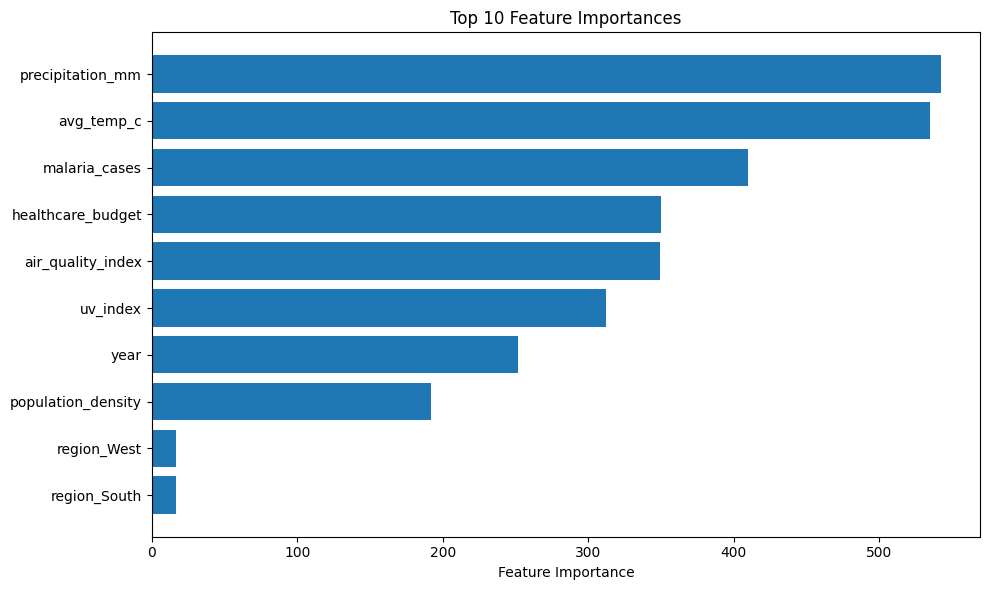

In [18]:
regions = [col for col in df.columns if col.startswith('region_')]

features = ['avg_temp_c', 'precipitation_mm', 'air_quality_index',
           'malaria_cases', 'year', 'uv_index', 'population_density',
           'healthcare_budget'] + regions

X = df[features]
y = df['dengue_cases']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = ['avg_temp_c', 'precipitation_mm', 'air_quality_index',
                   'malaria_cases', 'year', 'uv_index', 'population_density',
                   'healthcare_budget']

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

model = LGBMRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Model Performance:")
print(f"R-squared: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")


feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### **GRADIENT BOOSTING REGRESSOR**

In [19]:
regions = [ col for col in df.columns if col.startswith('region_')]
features = ['avg_temp_c', 'precipitation_mm', 'air_quality_index',
            'malaria_cases', 'year', 'uv_index', 'population_density', 'healthcare_budget',*regions]
X = df[features]
Y = df['dengue_cases']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

R-squared: 0.2864261339167208
Mean Squared Error: 1020.9158764981987
Mean Absolute Error: 27.70407793873091
Root Mean Squared Error: 31.95177423083417


### **XG BOOST**

In [20]:
regions = [col for col in df.columns if col.startswith('region_')]

df['temp_precip_interaction'] = df['avg_temp_c'] * df['precipitation_mm']
df['air_quality_temp_interaction'] = df['air_quality_index'] * df['avg_temp_c']
df['uv_precip_interaction'] = df['uv_index'] * df['precipitation_mm']
df['env_stress_score'] = df['precipitation_mm'] * df['air_quality_index'] * df['uv_index']

features = [
    'avg_temp_c', 'precipitation_mm', 'air_quality_index',
    'malaria_cases', 'year', 'uv_index', 'population_density',
    'healthcare_budget', 'temp_precip_interaction',
    'air_quality_temp_interaction', 'uv_precip_interaction', 'env_stress_score', *regions
]

X = df[features]
y = df['dengue_cases']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

numeric_features = [
    'avg_temp_c', 'precipitation_mm', 'air_quality_index',
    'malaria_cases', 'year', 'uv_index', 'population_density',
    'healthcare_budget', 'temp_precip_interaction',
    'air_quality_temp_interaction', 'uv_precip_interaction', 'env_stress_score'
]

X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

R-squared: 0.22780442237854004
Mean Squared Error: 1104.786376953125
Mean Absolute Error: 28.461904525756836
Root Mean Squared Error: 33.23832702636719


**LINEAR REGRESSION**

In [21]:
regions = [col for col in df.columns if col.startswith('region_')]

df['temp_precip_interaction'] = df['avg_temp_c'] * df['precipitation_mm']
df['air_quality_temp_interaction'] = df['air_quality_index'] * df['avg_temp_c']
df['uv_precip_interaction'] = df['uv_index'] * df['precipitation_mm']
df['env_stress_score'] = df['precipitation_mm'] * df['air_quality_index'] * df['uv_index']

features = [
    'avg_temp_c', 'precipitation_mm', 'air_quality_index',
    'malaria_cases', 'year', 'uv_index', 'population_density',
    'healthcare_budget', 'temp_precip_interaction',
    'air_quality_temp_interaction', 'uv_precip_interaction', 'env_stress_score', *regions
]

X = df[features]
y = df['dengue_cases']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

numeric_features = [
    'avg_temp_c', 'precipitation_mm', 'air_quality_index',
    'malaria_cases', 'year', 'uv_index', 'population_density',
    'healthcare_budget', 'temp_precip_interaction',
    'air_quality_temp_interaction', 'uv_precip_interaction', 'env_stress_score'
]

X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

R-squared: 0.2891655434487178
Mean Squared Error: 1016.9965812207566
Mean Absolute Error: 27.66269739558839
Root Mean Squared Error: 31.890383836209256


### **FACEBOOK PROPHET**

DEBUG:cmdstanpy:input tempfile: /tmp/tmpk8fle79o/o97mvn20.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk8fle79o/4tl0o7rf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72275', 'data', 'file=/tmp/tmpk8fle79o/o97mvn20.json', 'init=/tmp/tmpk8fle79o/4tl0o7rf.json', 'output', 'file=/tmp/tmpk8fle79o/prophet_modelqsbn16ry/prophet_model-20250825205402.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:54:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:54:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds   yhat  yhat_lower  yhat_upper
295 2024-08-01 72.450      25.350     115.655
296 2024-09-01 69.632      24.841     115.424
297 2024-10-01 69.966      21.113     111.486
298 2024-11-01 73.951      29.734     122.012
299 2024-12-01 82.081      38.252     130.178


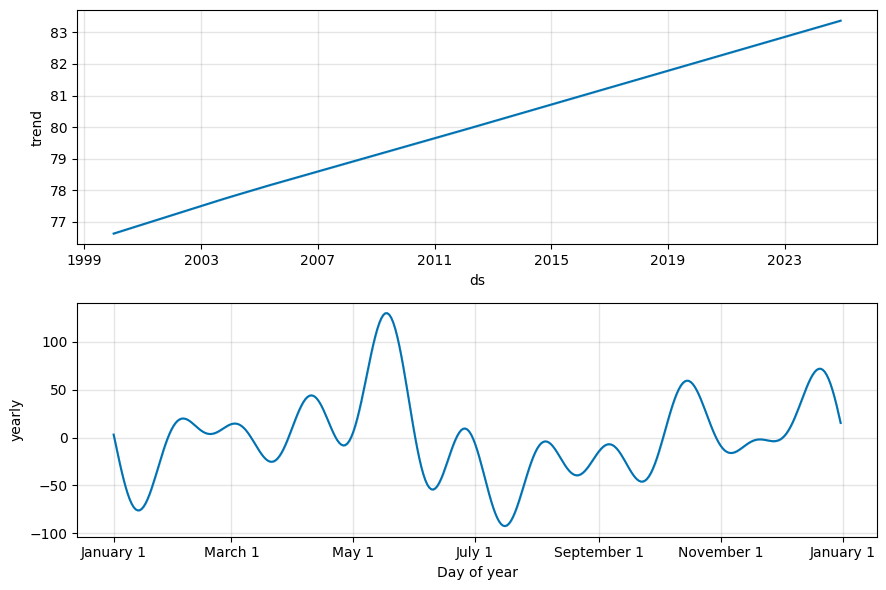

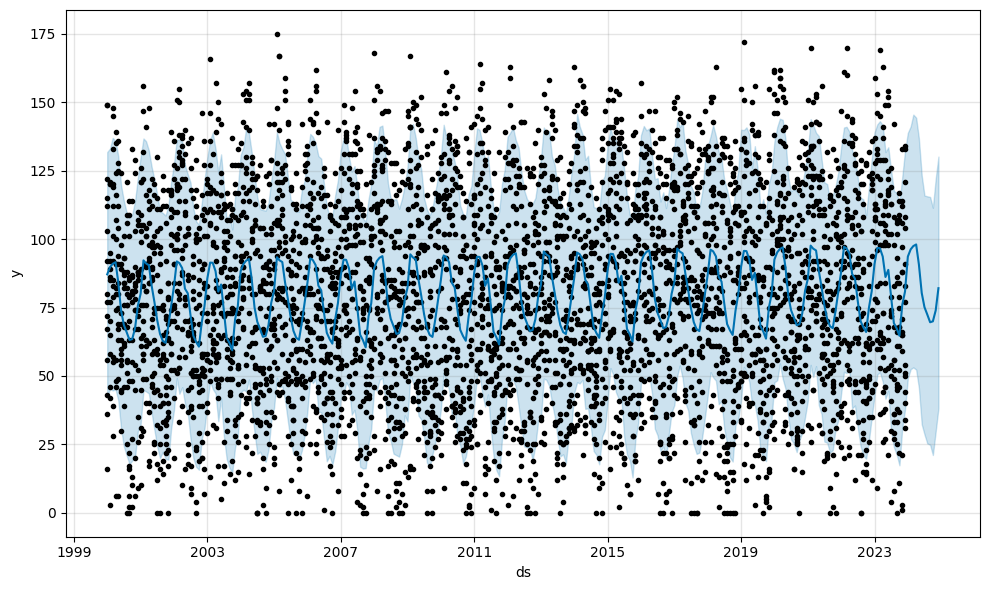

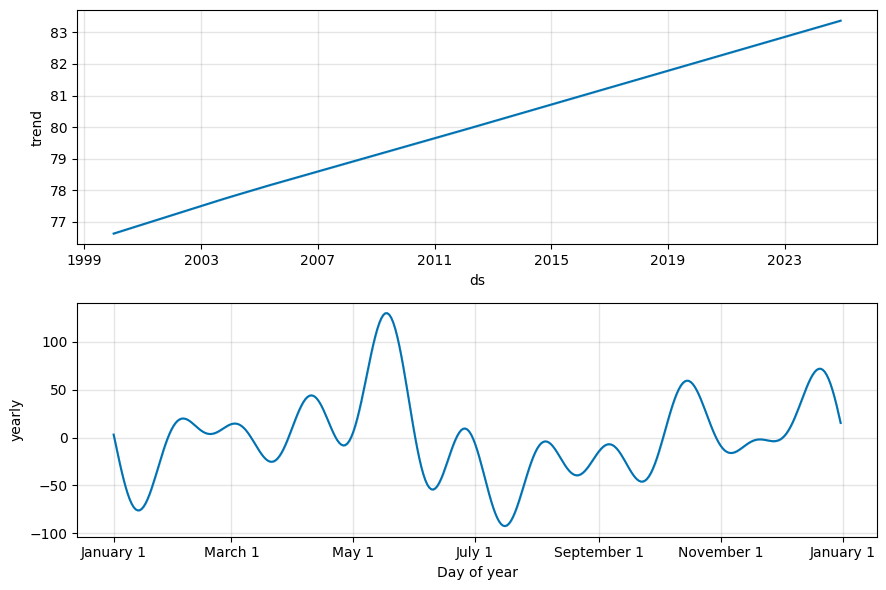

In [22]:
df['ds'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df = df.sort_values(by='ds')

regions = [col for col in df.columns if col.startswith('region_')]
df_prophet = df[['ds', 'dengue_cases', 'country'] + regions].copy()
df_prophet = df_prophet.rename(columns={'dengue_cases': 'y'})

region_df = df_prophet[df_prophet['region_East'] == True].dropna(subset=['y'])


model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(region_df)

future = model.make_future_dataframe(periods=12, freq='MS')

forecast = model.predict(future)

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

model.plot(forecast)
model.plot_components(forecast)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk8fle79o/qm_oh6um.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk8fle79o/jfcz28os.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75045', 'data', 'file=/tmp/tmpk8fle79o/qm_oh6um.json', 'init=/tmp/tmpk8fle79o/jfcz28os.json', 'output', 'file=/tmp/tmpk8fle79o/prophet_modelmuijbsxn/prophet_model-20250825205410.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:54:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:54:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


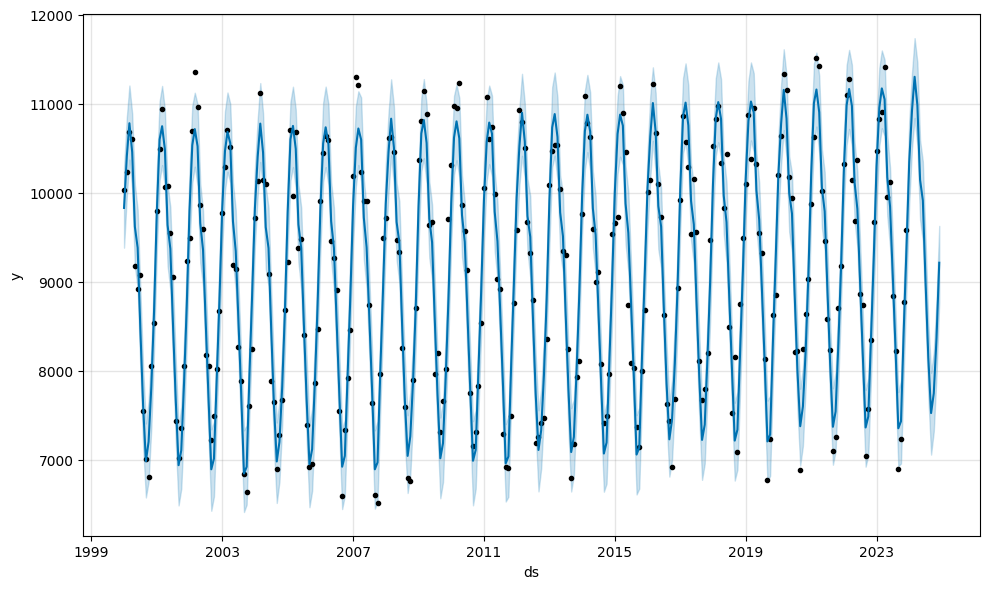

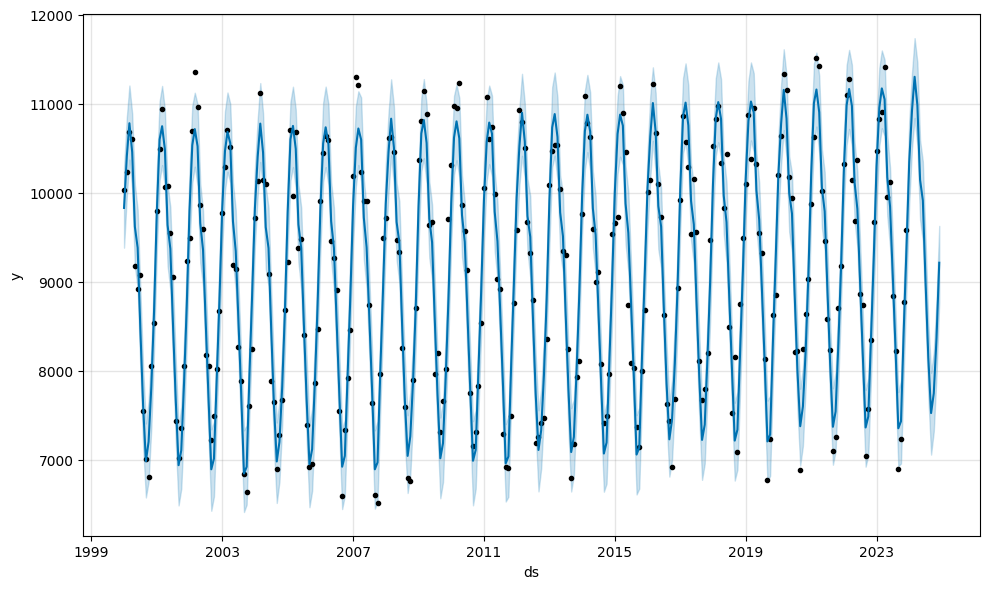

In [23]:
df_prophet = df.groupby(['year', 'month'])['dengue_cases'].sum().reset_index()
df_prophet['ds'] = pd.to_datetime(df_prophet[['year', 'month']].assign(day=1))
df_prophet['y'] = df_prophet['dengue_cases']
df_prophet = df_prophet[['ds', 'y']]

model = Prophet()
model.fit(df_prophet)

future = model.make_future_dataframe(periods=12, freq='MS')

forecast = model.predict(future)

model.plot(forecast)


Initializing and training Prophet model...
Model training complete.

Generating future predictions...
Forecast generated.

Plotting forecast...


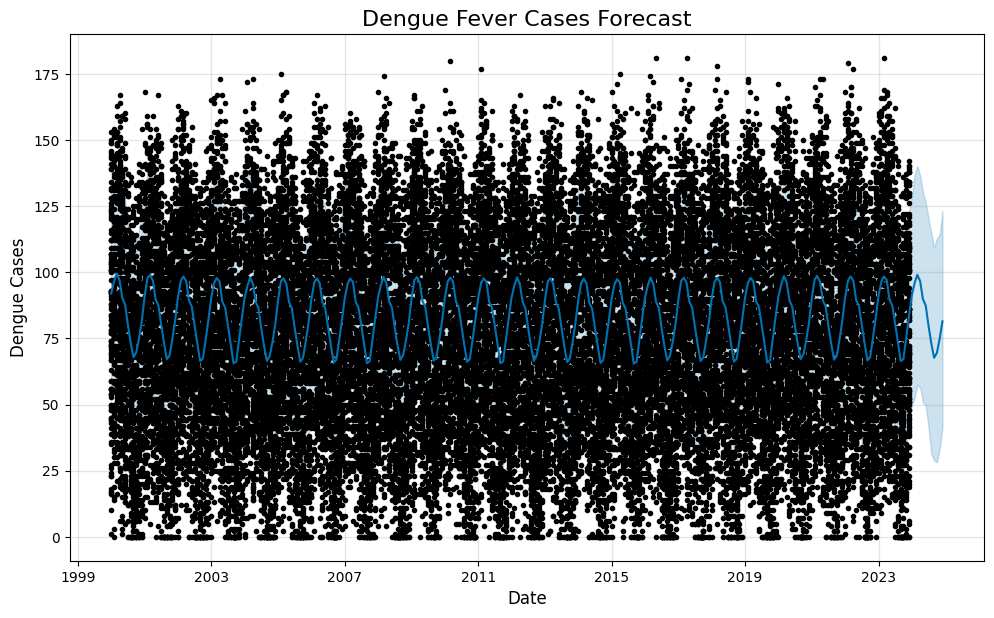

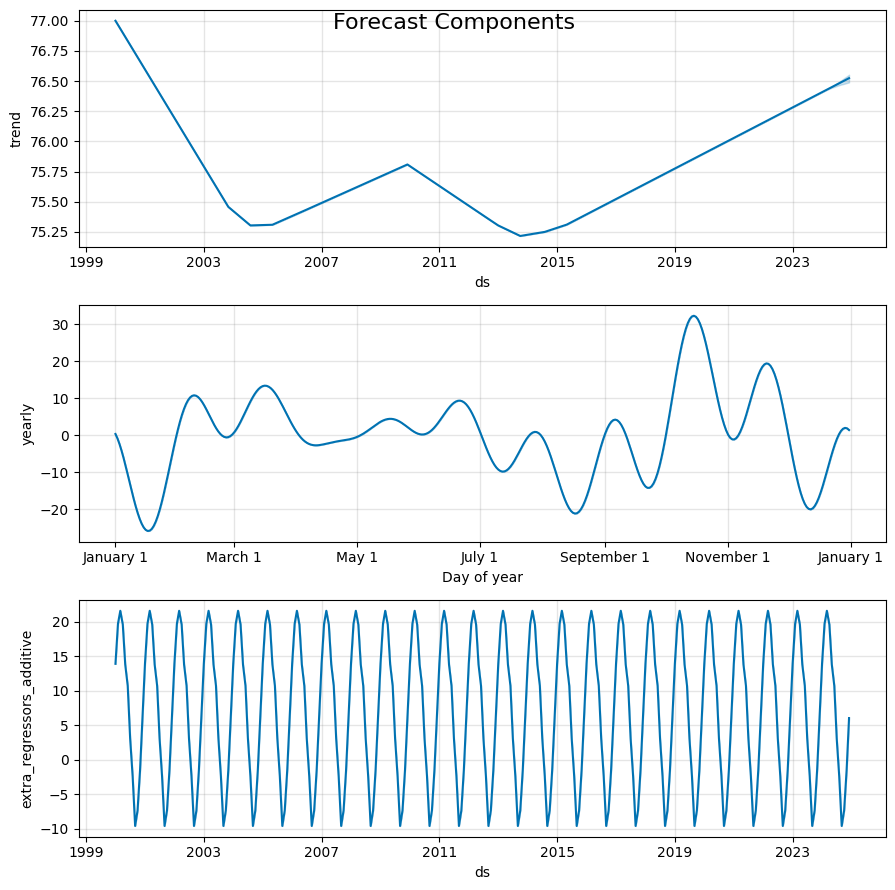


Future Dengue Cases Forecast (Last 12 Months):
        ds   yhat  yhat_lower  yhat_upper
2024-01-01 91.334      49.718     128.863
2024-02-01 95.979      52.670     137.029
2024-03-01 99.024      57.530     140.111
2024-04-01 96.607      56.286     136.574
2024-05-01 89.873      50.933     130.338
2024-06-01 87.400      49.619     126.241
2024-07-01 79.937      41.455     120.491
2024-08-01 73.125      31.256     114.839
2024-09-01 67.671      28.920     109.288
2024-10-01 69.486      28.165     112.808
2024-11-01 74.890      33.386     114.219
2024-12-01 81.453      41.261     123.214

Script execution complete.


In [24]:
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

df['ds'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

df = df.rename(columns={'dengue_cases': 'y'})

prophet_df = df[['ds', 'y', 'avg_temp_c', 'precipitation_mm',
                 'air_quality_index', 'uv_index', 'malaria_cases',
                 'population_density', 'healthcare_budget']].copy()

for col in ['avg_temp_c', 'precipitation_mm', 'air_quality_index',
            'uv_index', 'malaria_cases', 'population_density', 'healthcare_budget']:
    prophet_df[col] = pd.to_numeric(prophet_df[col], errors='coerce')

    if prophet_df[col].isnull().any():
        prophet_df[col] = prophet_df[col].fillna(prophet_df[col].mean())
        print(f"Warning: NaNs found and filled in column '{col}'.")



print("\nInitializing and training Prophet model...")
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
)


regressors = ['avg_temp_c', 'precipitation_mm', 'air_quality_index',
              'uv_index', 'malaria_cases', 'population_density', 'healthcare_budget']
for col in regressors:
    m.add_regressor(col)

m.fit(prophet_df)
print("Model training complete.")

print("\nGenerating future predictions...")

future_periods = 12
future = m.make_future_dataframe(periods=future_periods, freq='MS')

last_known_values = prophet_df[regressors].iloc[-1].to_dict()
for col in regressors:
    if col not in ['avg_temp_c', 'precipitation_mm']:
        future[col] = future['ds'].apply(lambda x: last_known_values.get(col))

prophet_df['month'] = prophet_df['ds'].dt.month
monthly_averages = prophet_df.groupby('month')[['avg_temp_c', 'precipitation_mm']].mean().reset_index()

future['month'] = future['ds'].dt.month
for col in ['avg_temp_c', 'precipitation_mm']:
    future = pd.merge(future, monthly_averages[['month', col]], on='month', how='left', suffixes=('', '_avg_merged'))
    future[col] = future[f'{col}']

cols_to_drop = [f'{col}_avg_merged' for col in ['avg_temp_c', 'precipitation_mm']] + ['month']
future = future.drop(columns=cols_to_drop, errors='ignore')

for col in regressors:
    if col not in future.columns:
        future[col] = prophet_df[col].iloc[-1]
    future[col] = pd.to_numeric(future[col], errors='coerce').fillna(prophet_df[col].mean()) # Final NaN check

forecast = m.predict(future)
print("Forecast generated.")

print("\nPlotting forecast...")
fig1 = m.plot(forecast)
plt.title('Dengue Fever Cases Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Dengue Cases', fontsize=12)
plt.grid(True)
plt.show()

fig2 = m.plot_components(forecast)
plt.suptitle('Forecast Components', fontsize=16)
plt.show()

print("\nFuture Dengue Cases Forecast (Last 12 Months):")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(future_periods).to_string(index=False))

print("\nScript execution complete.")

In [25]:
print(df[['year', 'month']].drop_duplicates().sort_values(['year', 'month']))

       year  month
0      2000      1
4321   2000      2
5474   2000      3
33411  2000      4
22756  2000      5
...     ...    ...
26203  2023      8
21020  2023      9
17565  2023     10
1150   2023     11
17279  2023     12

[288 rows x 2 columns]


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


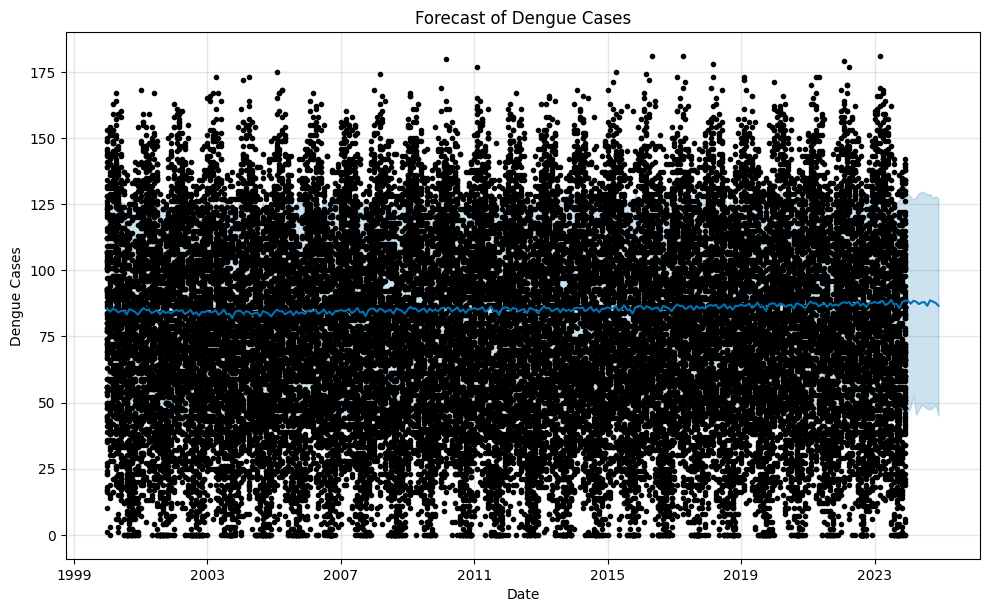

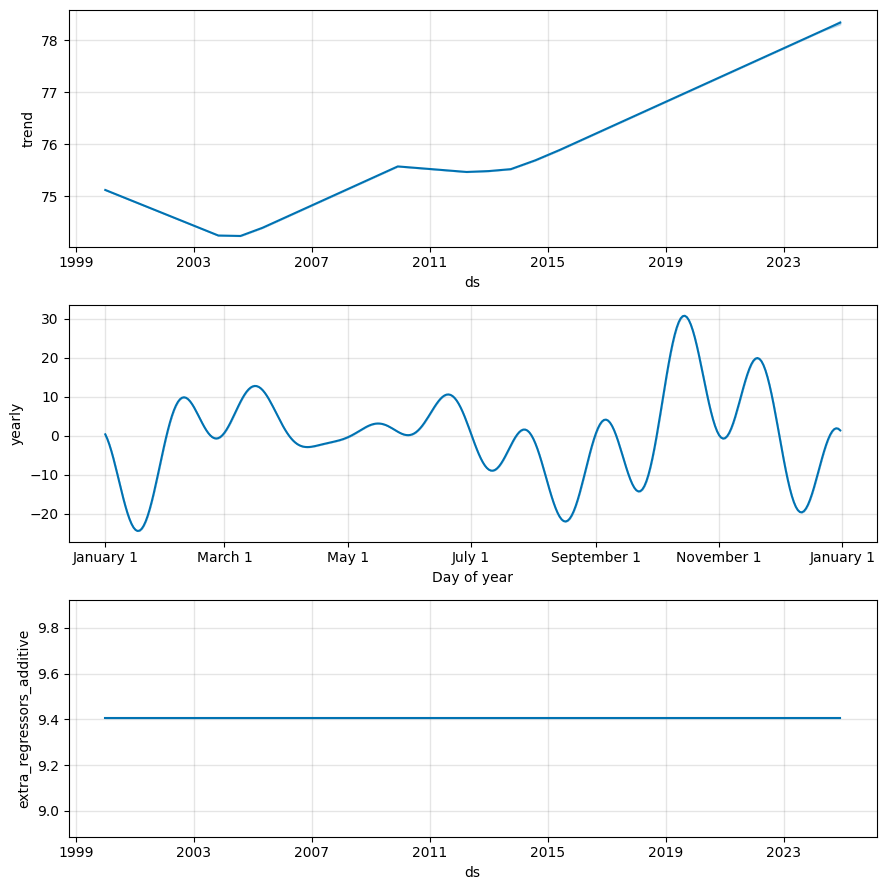

In [41]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

df = df[df['year'].between(2000, 2030)]

# 2. Create a proper datetime column and sort
df['ds'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df = df.sort_values('ds').reset_index(drop=True)

# 3. Prepare data for Prophet - Use 'y' as the target
# Assuming 'y' is the column containing dengue cases after previous renaming steps
df_prophet = df[['ds', 'y', 'avg_temp_c', 'precipitation_mm', 'air_quality_index', 'uv_index']].copy()


# Ensure 'ds' is datetime
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])


# 4. Train Prophet model
model = Prophet()
model.add_regressor('avg_temp_c')
model.add_regressor('precipitation_mm')
model.add_regressor('air_quality_index')
model.add_regressor('uv_index')

# Select only the necessary columns for training, including regressors
train_df = df_prophet[['ds', 'y', 'avg_temp_c', 'precipitation_mm', 'air_quality_index', 'uv_index']]


model.fit(train_df)

# 5. Create future dataframe and predict
future = model.make_future_dataframe(periods=12, freq='MS') # Example: Predict 12 months into the future


last_regressor_values = train_df[['avg_temp_c', 'precipitation_mm', 'air_quality_index', 'uv_index']].iloc[-1].to_dict()
for col, value in last_regressor_values.items():
    future[col] = value


forecast = model.predict(future)


model.plot(forecast)
plt.title("Forecast of Dengue Cases")
plt.xlabel("Date")
plt.ylabel("Dengue Cases")
plt.show()

model.plot_components(forecast)
plt.show()

# Evaluation metrics can only be calculated if you split your data into training and testing sets before fitting.
# If you want to evaluate, you need to adjust the code to split the data first.
# For now, I've commented out the evaluation part.

# 8. Evaluate model (Commented out as no test set was used for fitting)
# To evaluate, you would need a test set with 'ds' and 'y' columns and the corresponding 'yhat' from the forecast
# For example:
# train_size = int(len(df_prophet) * 0.8) # Define train_size if needed for evaluation
# df_eval = df_prophet.iloc[train_size:].copy() # Assuming df_prophet was split into train and test
# df_eval = df_eval.merge(forecast[['ds', 'yhat']], on='ds')
# r2 = r2_score(df_eval['y'], df_eval['yhat'])
# mse = mean_squared_error(df_eval['y'], df_eval['yhat'])
# mae = mean_absolute_error(df_eval['y'], df_eval['yhat'])

# print(f"R²: {r2:.3f}")
# print(f"MSE: {mse:.3f}")
# print(f"MAE: {mae:.3f}")

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


R²: 0.081
MSE: 1295.97
MAE: 30.21
rmse: 36.00


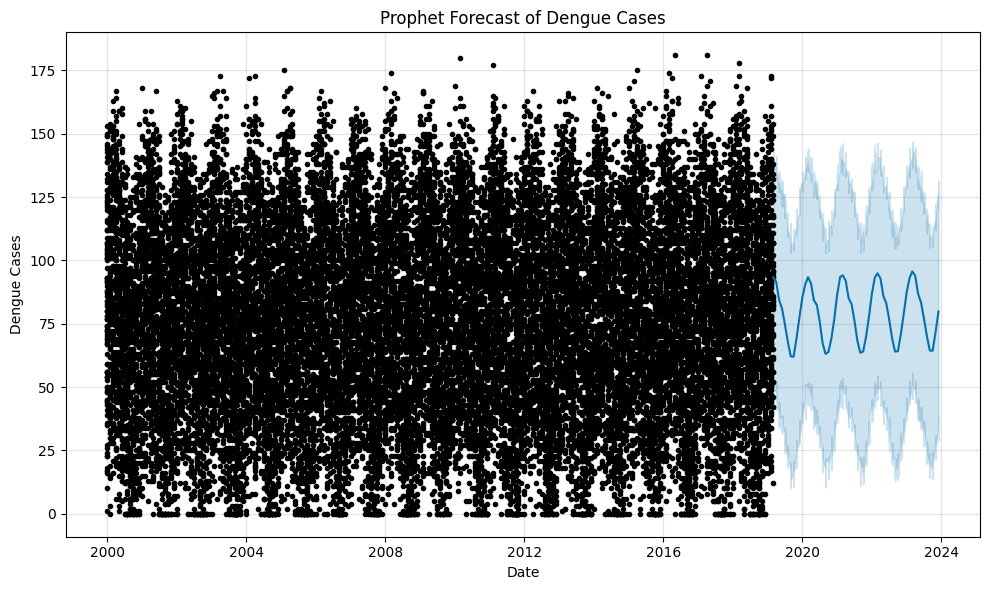

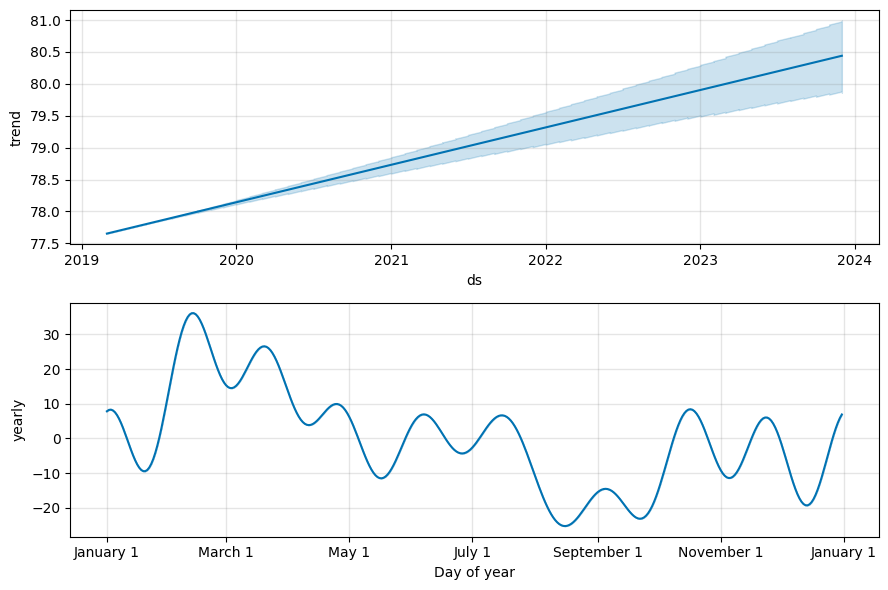

In [44]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

df['ds'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df = df.sort_values('ds').reset_index(drop=True)

df_prophet = df[['ds', 'y']].copy()
df_prophet = df_prophet.rename(columns={'y': 'y'})

train_size = int(len(df_prophet) * 0.8)
train = df_prophet.iloc[:train_size]
test = df_prophet.iloc[train_size:]

model = Prophet()
model.fit(train)

future = test[['ds']].copy()
forecast = model.predict(future)

df_eval = test.copy()
df_eval = df_eval.merge(forecast[['ds', 'yhat']], on='ds')

r2 = r2_score(df_eval['y'], df_eval['yhat'])
mse = mean_squared_error(df_eval['y'], df_eval['yhat'])
mae = mean_absolute_error(df_eval['y'], df_eval['yhat'])
rmse = root_mean_squared_error(df_eval['y'], df_eval['yhat'])

print(f"R²: {r2:.3f}")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"rmse: {rmse:.2f}")

model.plot(forecast)
plt.title("Prophet Forecast of Dengue Cases")
plt.xlabel("Date")
plt.ylabel("Dengue Cases")
plt.tight_layout()
plt.show()

model.plot_components(forecast)
plt.show()


### **SARIMAX**

R²: 0.283
MSE: 1008.98
MAE: 27.57
rmse: 31.76


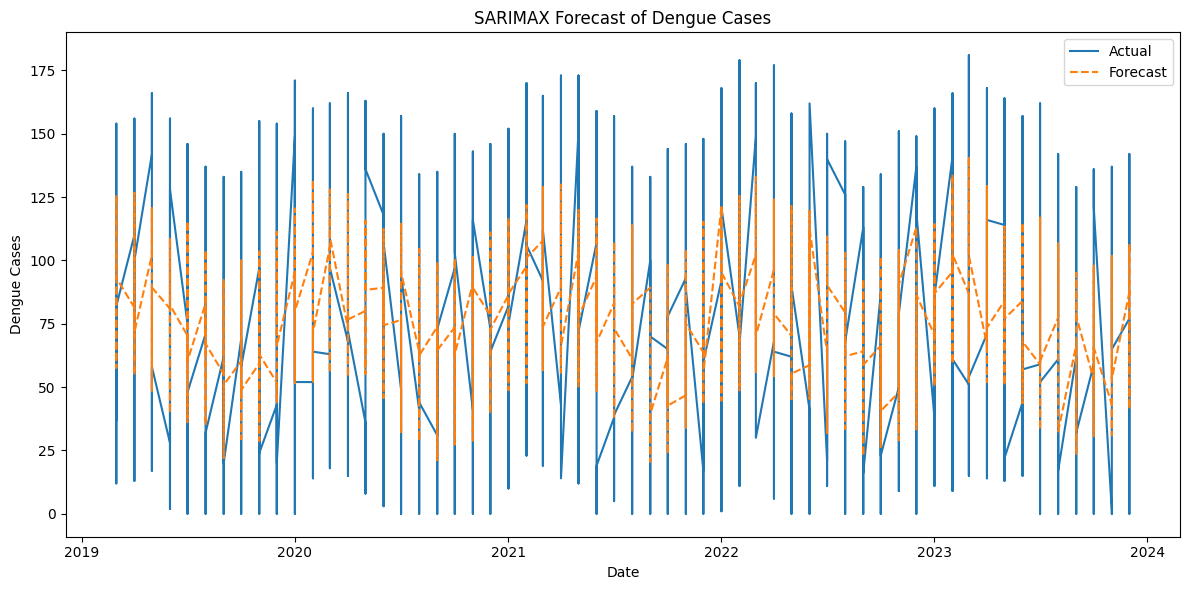

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

df = df[df['year'] > 0]

df = df.reset_index(drop=True)
df['ds'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df = df.sort_values('ds').reset_index(drop=True)

target = 'y'
exog_vars = ['avg_temp_c', 'precipitation_mm', 'air_quality_index', 'malaria_cases']


y = df[target]
X = df[exog_vars]

train_size = int(len(df) * 0.8)
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]

model = SARIMAX(y_train, exog=X_train, order=(1,1,1), seasonal_order=(1,1,1,12))
results = model.fit(disp=False)

forecast = results.predict(start=len(y_train), end=len(y)-1, exog=X_test)

r2 = r2_score(y_test, forecast)
mse = mean_squared_error(y_test, forecast)
mae = mean_absolute_error(y_test, forecast)
rmse = root_mean_squared_error(y_test, forecast)

print(f"R²: {r2:.3f}")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"rmse: {rmse:.2f}")


plt.figure(figsize=(12, 6))
plt.plot(df['ds'].iloc[train_size:], y_test, label='Actual')
plt.plot(df['ds'].iloc[train_size:], forecast, label='Forecast', linestyle='--')
plt.title('SARIMAX Forecast of Dengue Cases')
plt.xlabel('Date')
plt.ylabel('Dengue Cases')
plt.legend()
plt.tight_layout()
plt.show()

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# -----------------------------
# 1. Prepare your data
# -----------------------------
# Assume df has 'year', 'month', 'dengue_cases', and external features
df['ds'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df = df.sort_values('ds').reset_index(drop=True)

# Define target and exogenous variables
target = 'y'
exog_vars = ['avg_temp_c', 'precipitation_mm', 'air_quality_index', 'malaria_cases']

y = df[target]
X = df[exog_vars]

# -----------------------------
# 2. Train-test split (e.g., last 20% as test)
# -----------------------------
train_size = int(len(df) * 0.8)
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
test_dates = df['ds'].iloc[train_size:]

# -----------------------------
# 3. Fit SARIMAX model
# -----------------------------
model = SARIMAX(y_train, exog=X_train, order=(1,1,1), seasonal_order=(1,1,1,12))
results = model.fit(disp=False)

# -----------------------------
# 4. Forecast
# -----------------------------
forecast = results.predict(start=len(y_train), end=len(y)-1, exog=X_test)

# -----------------------------
# 5. Evaluation
# -----------------------------
r2 = r2_score(y_test, forecast)
mse = mean_squared_error(y_test, forecast)
mae = mean_absolute_error(y_test, forecast)
rmse = root_mean_squared_error(y_test, forecast)

print(f"R²: {r2:.3f}")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"rmse: {rmse:.2f}")

# -----------------------------
# 6. Forecast vs Actual Table
# -----------------------------
# print("\nForecast vs Actual:")
# comparison = pd.DataFrame({
#     'Date': test_dates.values,
#     'Actual': y_test.values,
#     'Forecast': forecast.values,
#     'Error': y_test.values - forecast.values
# })
# print(comparison.to_string(index=False))

# -----------------------------
# 7. Plot actual vs forecast
# -----------------------------
# plt.figure(figsize=(12, 6))
# plt.plot(test_dates, y_test, label='Actual')
# plt.plot(test_dates, forecast, label='Forecast', linestyle='--')
# plt.title('SARIMAX Forecast of Dengue Cases')
# plt.xlabel('Date')
# plt.ylabel('Dengue Cases')
# plt.legend()
# plt.tight_layout()
# plt.show()

R²: 0.284
MSE: 1009.28
MAE: 27.55
rmse: 31.77


### **DECISION TREES**

In [ ]:
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

df['dayofyear'] = df['date'].dt.dayofyear
df['weekofyear'] = df['date'].dt.isocalendar().week
df['quarter'] = df['date'].dt.quarter
df['is_rainy_season'] = df['month'].isin([4, 5, 6, 10, 11, 12]).astype(int)
df['temp_uv'] = df['avg_temp_c'] * df['uv_index']
df['precip_density'] = df['precipitation_mm'] * df['population_density']

df['cases_lag1'] = df['dengue_cases'].shift(1)
df['cases_lag2'] = df['dengue_cases'].shift(2)
df['cases_lag3'] = df['dengue_cases'].shift(3)

df['cases_rolling_mean_3'] = df['dengue_cases'].rolling(window=3).mean()
df['precip_rolling_mean_3'] = df['precipitation_mm'].rolling(window=3).mean()

df['Future_Cases'] = df['dengue_cases'].shift(-1)

df = df.dropna(subset=[
    'cases_lag1', 'cases_lag2', 'cases_lag3',
    'cases_rolling_mean_3', 'precip_rolling_mean_3',
    'Future_Cases'
])

X = df.drop(columns=['dengue_cases', 'Future_Cases', 'date'])
y = df['Future_Cases']

X = pd.get_dummies(X, drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

tree_model = DecisionTreeRegressor(max_depth=10, random_state=42)
tree_model.fit(X_train, y_train)

y_pred = tree_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Decision Tree MSE:", mse)
print("Decision Tree R² Score:", r2)


Decision Tree MSE: 1246.8953981849347
Decision Tree R² Score: 0.10387408846410218


### **CROSS VALIDATION**

In [ ]:
# linear regression
model = LinearRegression()
tscv = TimeSeriesSplit(n_splits=5)

scores = cross_val_score(model, X, y, cv=tscv, scoring=make_scorer(r2_score))

print("TimeSeriesSplit R² scores:", scores)
print("Mean R²:", np.mean(scores))
print("Standard Deviation of R²:", np.std(scores))

TimeSeriesSplit R² scores: [0.25850543 0.27924201 0.27771132 0.2661319  0.27299874]
Mean R²: 0.2709178804660796
Standard Deviation of R²: 0.0077038511352838955


In [ ]:
# gradient booster
model = GradientBoostingRegressor()
tscv = TimeSeriesSplit(n_splits=5)

scores = cross_val_score(model, X, y, cv=tscv, scoring=make_scorer(r2_score))

print("TimeSeriesSplit R² scores:", scores)
print("Mean R²:", np.mean(scores))
print("Standard Deviation of R²:", np.std(scores))

TimeSeriesSplit R² scores: [0.24790579 0.2645711  0.27202493 0.25885645 0.26777579]
Mean R²: 0.2622268115231806
Standard Deviation of R²: 0.008351537773005183


In [ ]:
# lgbm
model = LGBMRegressor()
tscv = TimeSeriesSplit(n_splits=5)

scores = cross_val_score(model, X, y, cv=tscv, scoring=make_scorer(r2_score))

print("TimeSeriesSplit R² scores:", scores)
print("Mean R²:", np.mean(scores))
print("Standard Deviation of R²:", np.std(scores))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 5760, number of used features: 17
[LightGBM] [Info] Start training from score 71.803819
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2331
[LightGBM] [Info] Number of data points in the train set: 11520, number of used features: 17
[LightGBM] [Info] Start training from score 70.749566
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total B

In [ ]:
# random forest
model = RandomForestRegressor()
tscv = TimeSeriesSplit(n_splits=5)

scores = cross_val_score(model, X, y, cv=tscv, scoring=make_scorer(r2_score))

print("TimeSeriesSplit R² scores:", scores)
print("Mean R²:", np.mean(scores))
print("Standard Deviation of R²:", np.std(scores))

TimeSeriesSplit R² scores: [0.2126976  0.23670503 0.24028809 0.2300637  0.24160706]
Mean R²: 0.23227229596332633
Standard Deviation of R²: 0.010574369344888885


In [ ]:
# xgboost
model = XGBRegressor()
tscv = TimeSeriesSplit(n_splits=5)

scores = cross_val_score(model, X, y, cv=tscv, scoring=make_scorer(r2_score))

print("TimeSeriesSplit R² scores:", scores)
print("Mean R²:", np.mean(scores))
print("Standard Deviation of R²:", np.std(scores))

TimeSeriesSplit R² scores: [0.08719915 0.14565253 0.18349659 0.18200237 0.20822001]
Mean R²: 0.16131412982940674
Standard Deviation of R²: 0.042091665688795465


### **FORECAST PER FOR COUNTRY**


Initializing and training Prophet model...
Model training complete.

Generating future predictions...
Forecast generated.

Plotting forecast...


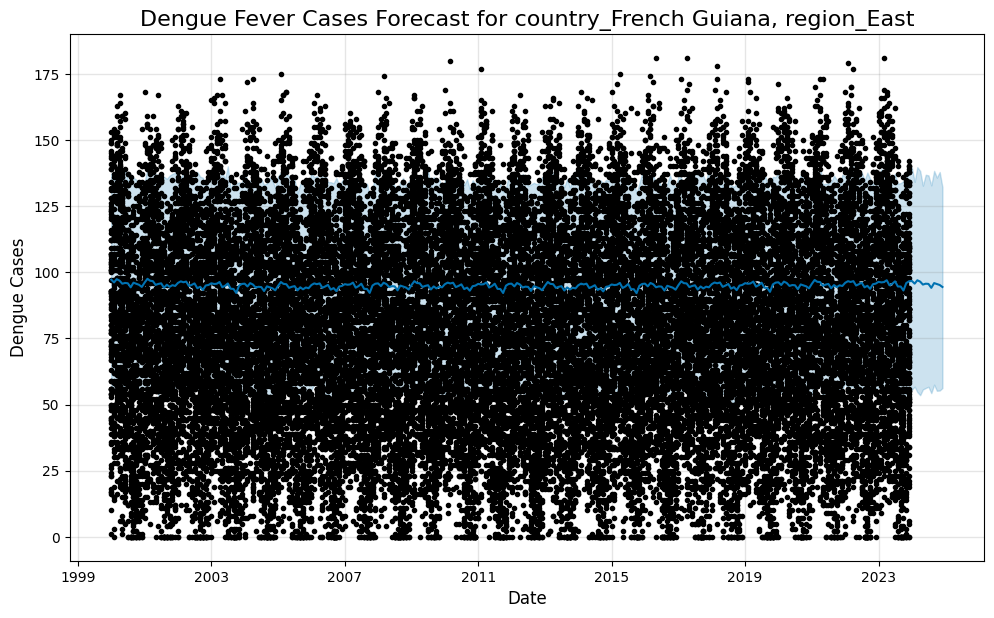

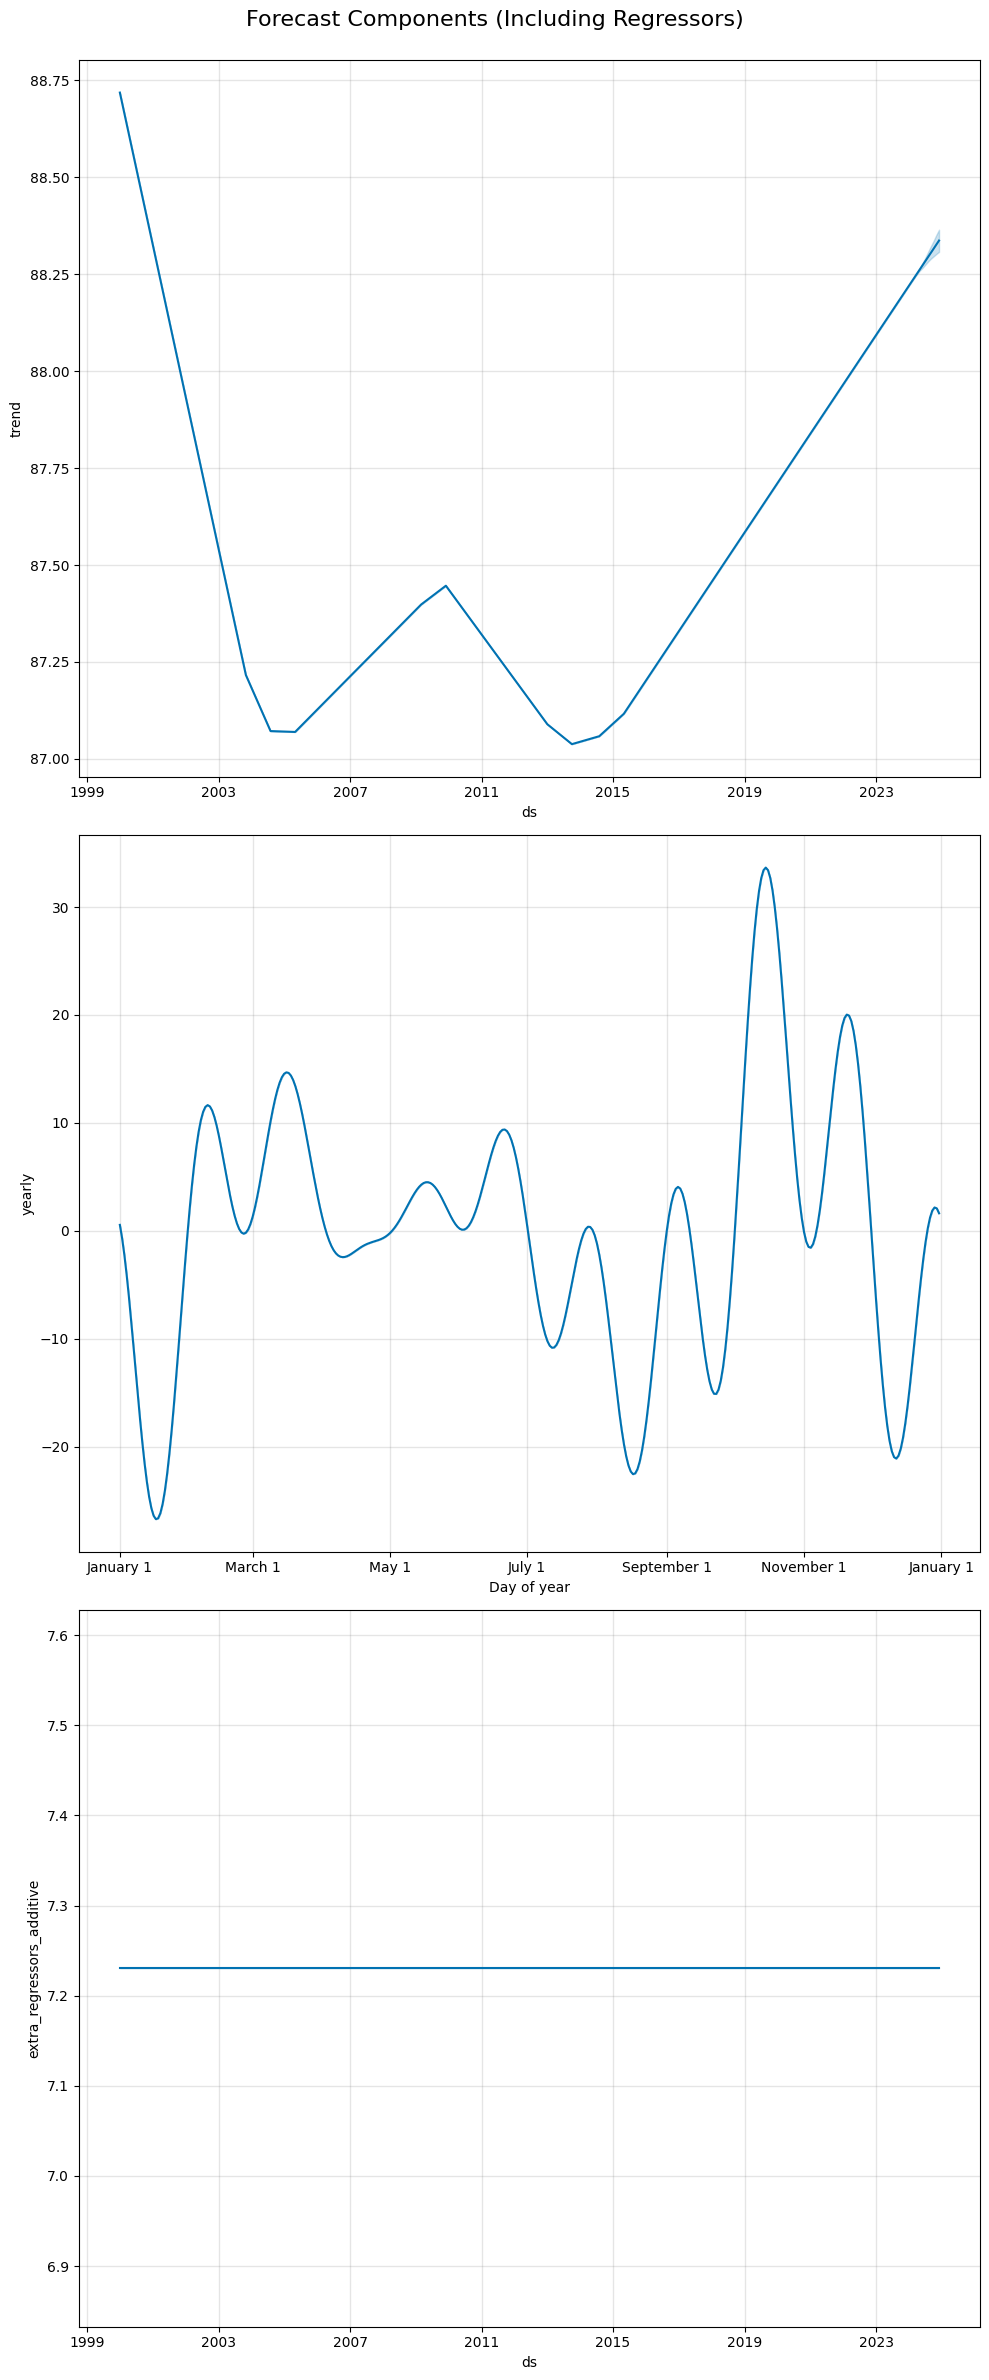


Future Dengue Cases Forecast for country_French Guiana, region_East (Next 12 Months):
        ds   yhat  yhat_lower  yhat_upper
2024-01-01 96.710      55.571     139.554
2024-02-01 95.687      56.751     134.170
2024-03-01 96.965      54.707     139.736
2024-04-01 96.452      53.512     138.295
2024-05-01 95.332      55.685     132.732
2024-06-01 95.666      56.245     136.844
2024-07-01 95.583      56.698     136.614
2024-08-01 94.104      54.290     132.834
2024-09-01 95.892      57.486     138.326
2024-10-01 95.546      55.189     135.771
2024-11-01 95.176      55.281     137.892
2024-12-01 94.419      56.223     132.145

Script execution complete.


In [ ]:
country_columns = [col for col in df.columns if col.startswith('country_')]
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

df['ds'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

df = df.rename(columns={'dengue_cases': 'y'})

df_encoded = pd.get_dummies(df, columns=['country', 'region'], prefix=['country', 'region'])

original_regressors = ['avg_temp_c', 'precipitation_mm', 'air_quality_index',
                       'uv_index', 'malaria_cases', 'population_density', 'healthcare_budget']

encoded_regressor_cols = [col for col in df_encoded.columns if col.startswith('country_') or col.startswith('region_')]

all_regressors = original_regressors + encoded_regressor_cols

prophet_df = df_encoded[['ds', 'y'] + all_regressors].copy()

for col in all_regressors:
    prophet_df[col] = pd.to_numeric(prophet_df[col], errors='coerce')
    if prophet_df[col].isnull().any():
        if col in encoded_regressor_cols:
            prophet_df[col] = prophet_df[col].fillna(0)
        else:
            prophet_df[col] = prophet_df[col].fillna(prophet_df[col].mean())
        print(f"Warning: NaNs found and filled in column '{col}'.")


print("\nInitializing and training Prophet model...")
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

for col in all_regressors:
    m.add_regressor(col)

m.fit(prophet_df)
print("Model training complete.")


print("\nGenerating future predictions...")

future_periods = 12

future = m.make_future_dataframe(periods=future_periods, freq='MS')

last_known_values_global = prophet_df[original_regressors].iloc[-1].to_dict()


prophet_df['month'] = prophet_df['ds'].dt.month
monthly_averages_global = prophet_df.groupby('month')[['avg_temp_c', 'precipitation_mm']].mean().reset_index()

future['month'] = future['ds'].dt.month
for col in ['avg_temp_c', 'precipitation_mm']:
    future = pd.merge(future, monthly_averages_global[['month', col]], on='month', how='left', suffixes=('', '_avg_merged'))
    future[col] = future[f'{col}']
    future = future.drop(columns=[f'{col}'])

for col in original_regressors:
    if col not in ['avg_temp_c', 'precipitation_mm']:
        future[col] = future['ds'].apply(lambda x: last_known_values_global.get(col))

TARGET_COUNTRY = 'country_French Guiana'
TARGET_REGION = 'region_East'

for col in encoded_regressor_cols:
    if col == f'country_{TARGET_COUNTRY}':
        future[col] = 1
    else:
        future[col] = 0

for col in all_regressors:
    if col not in future.columns:
        print(f"Warning: Regressor '{col}' missing from 'future' DataFrame. Filling with mean.")
        future[col] = prophet_df[col].mean()

    future[col] = pd.to_numeric(future[col], errors='coerce').fillna(prophet_df[col].mean()) # Ensure numeric and no NaNs


future = future.drop(columns=['month'], errors='ignore')

forecast = m.predict(future)
print("Forecast generated.")


print("\nPlotting forecast...")
fig1 = m.plot(forecast)
plt.title(f'Dengue Fever Cases Forecast for {TARGET_COUNTRY}, {TARGET_REGION}', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Dengue Cases', fontsize=12)
plt.grid(True)
plt.show()

fig2 = m.plot_components(forecast)
fig2.set_size_inches(10, 25)
plt.suptitle('Forecast Components (Including Regressors)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

print(f"\nFuture Dengue Cases Forecast for {TARGET_COUNTRY}, {TARGET_REGION} (Next {future_periods} Months):")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(future_periods).to_string(index=False))

print("\nScript execution complete.")

### **CASES HEATMAP**

In [ ]:
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

df['ds'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df = df.rename(columns={'dengue_cases': 'y'})

print("\nGeocoding unique country/region combinations")

unique_locations_df = df[['country', 'region']].drop_duplicates().copy()

geolocator = Nominatim(user_agent="dengue_heatmap_app_v2")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1.5)

def get_coordinates(row):
    location_str = f"{row['region']}, {row['country']}"
    try:
        loc = geocode(location_str)
        if loc:
            print(f"Geocoded '{location_str}': ({loc.latitude:.4f}, {loc.longitude:.4f})")
            return loc.latitude, loc.longitude
        else:
            print(f"Could not geocode '{location_str}'.")
            return None, None
    except Exception as e:
        print(f"Error geocoding '{location_str}': {e}")
        return None, None

unique_locations_df[['latitude', 'longitude']] = unique_locations_df.apply(
    lambda row: pd.Series(get_coordinates(row)), axis=1
)

df_with_coords = pd.merge(df, unique_locations_df[['country', 'region', 'latitude', 'longitude']],
                          on=['country', 'region'], how='left')

df_with_coords.dropna(subset=['latitude', 'longitude'], inplace=True)

if df_with_coords.empty:
    print("No locations could be geocoded. Cannot create heatmap.")
    exit()

print("\nFinished geocoding.")
print("DataFrame head with coordinates:")
print(df_with_coords.head())

heatmap_data = df_with_coords.groupby(['country', 'region']).agg(
    avg_dengue_cases=('y', 'mean'),
    latitude=('latitude', 'first'),
    longitude=('longitude', 'first')
).reset_index()

heatmap_data = heatmap_data.sort_values(by='avg_dengue_cases', ascending=False)

print("\nAggregated data for heatmap:")
print(heatmap_data)

map_center_lat = heatmap_data['latitude'].mean()
map_center_lon = heatmap_data['longitude'].mean()

accra_lat, accra_lon = 5.6037, -0.1870
m = folium.Map(location=[accra_lat, accra_lon], zoom_start=6)

heat_data = [[row['latitude'], row['longitude'], row['avg_dengue_cases']]
             for index, row in heatmap_data.iterrows()]

if heat_data:
    HeatMap(heat_data).add_to(m)
    print("\nHeatmap layer added to the map.")
else:
    print("No valid heat data found. Heatmap will be empty.")

for index, row in heatmap_data.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"{row['region']}, {row['country']}: Avg Cases = {row['avg_dengue_cases']:.0f}"
    ).add_to(m)
    print(f"Added marker for {row['region']}, {row['country']}.")

print("\nDisplaying heatmap directly below...")



Geocoding unique country/region combinations
Could not geocode 'Central, Palestinian Territory'.
Geocoded 'North, Macao': (51.5138, 7.4668)


Could not geocode 'North, Antarctica (the territory South of 60 deg S)'.
Geocoded 'South, Slovenia': (52.0834, 4.3008)
Geocoded 'North, Saint Helena': (34.5166, -77.9155)
Geocoded 'Central, Japan': (35.6534, 139.7981)
Geocoded 'West, Saint Lucia': (-27.4940, 152.9976)
Geocoded 'West, United Arab Emirates': (-15.8508, -47.8897)
Geocoded 'North, French Polynesia': (-14.1002, -141.4890)
Geocoded 'East, Colombia': (34.7071, 33.0803)
Geocoded 'West, Pakistan': (34.0337, 72.4822)
Geocoded 'Central, Belgium': (50.3874, 4.8678)
Could not geocode 'East, Turkmenistan'.
Geocoded 'West, Portugal': (39.3316, -9.1786)
Geocoded 'West, Poland': (53.4398, 14.4970)


Could not geocode 'Central, Saint Kitts and Nevis'.


Geocoded 'West, Papua New Guinea': (-7.5000, 142.0000)


Geocoded 'West, Chad': (52.4856, -1.8988)
Could not geocode 'North, Slovakia (Slovak Republic)'.
Geocoded 'South, Grenada': (33.8058, -89.7703)
Geocoded 'South, Dominican Republic': (-34.0561, 150.7653)
Geocoded 'West, Malta': (43.8243, 17.0085)
Geocoded 'West, Ireland': (51.6788, -9.4510)


Geocoded 'South, Liberia': (35.0140, -82.6318)
Geocoded 'Central, Lesotho': (-29.3130, 27.4892)


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
               ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connection.py", line 516, in getresponse
    httplib_response = super().getresponse()
                       ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/http/client.py", line 1395, in getresponse
    response.begin()
  File "/usr/lib/python3.11/http/client.py", line 325, in begin
    version, status, reason = self._read_status()
                              ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/http/client.py", line 286, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/socket.py", line 718, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ssl.py", line

Could not geocode 'Central, Isle of Man'.
Could not geocode 'South, Pitcairn Islands'.
Geocoded 'East, Korea': (-7.2833, 112.7360)
Geocoded 'North, Congo': (1.1674, -49.9083)
Geocoded 'South, Morocco': (40.9418, -87.4480)


Geocoded 'East, American Samoa': (-14.2711, -170.5692)


Geocoded 'West, Kenya': (0.5090, 34.5731)
Geocoded 'West, Sweden': (56.0302, 14.1552)


Geocoded 'South, New Caledonia': (-22.2758, 166.6418)


Geocoded 'South, Palau': (-3.6085, 119.8377)
Geocoded 'North, Cyprus': (51.5085, 0.0640)
Geocoded 'Central, Guyana': (7.5186, -58.9707)
Geocoded 'South, Djibouti': (53.3900, -1.4597)
Geocoded 'Central, Bahamas': (-25.1883, -57.5205)
Geocoded 'North, Reunion': (35.0893, -80.9935)
Geocoded 'North, El Salvador': (13.8658, -89.8500)
Geocoded 'South, Montserrat': (-30.0287, -51.1906)


Geocoded 'North, Sao Tome and Principe': (52.3414, 4.8565)


Geocoded 'East, Saudi Arabia': (24.7062, 46.8027)


Geocoded 'Central, Togo': (0.6901, 32.2919)
Geocoded 'Central, Guam': (13.5000, 144.7925)
Geocoded 'West, South Africa': (-26.4572, 27.7634)
Geocoded 'South, Serbia': (45.3130, 19.9057)
Geocoded 'West, Iran': (36.8195, 50.8764)
Geocoded 'West, Uzbekistan': (50.1188, 8.6887)
Geocoded 'North, Israel': (8.7321, 14.0759)
Could not geocode 'Central, Wallis and Futuna'.
Geocoded 'North, Hong Kong': (22.3058, 114.1624)
Geocoded 'West, Dominica': (18.5154, -72.2936)
Geocoded 'South, Guinea-Bissau': (11.4088, -16.0042)
Geocoded 'South, Tuvalu': (51.4905, 0.2956)
Geocoded 'West, Mauritania': (-15.8381, -47.8817)
Could not geocode 'West, Micronesia'.


Geocoded 'East, Mozambique': (40.7534, -73.9654)
Geocoded 'North, Zimbabwe': (-20.1366, 28.4836)
Geocoded 'West, French Guiana': (4.8923, -52.3358)


Geocoded 'North, Ethiopia': (6.5505, 36.7270)
Geocoded 'Central, Cambodia': (11.5502, 104.9348)
Geocoded 'Central, San Marino': (3.2203, -74.8645)
Geocoded 'Central, Bangladesh': (25.7642, 89.2328)
Geocoded 'East, Bulgaria': (42.1928, 24.3508)
Geocoded 'North, Monaco': (43.7771, -79.4138)


Could not geocode 'North, Marshall Islands'.
Geocoded 'West, Peru': (38.8411, -79.0742)
Geocoded 'Central, Guadeloupe': (-16.5091, -68.1433)
Geocoded 'North, Christmas Island': (-10.4763, 105.6147)
Geocoded 'North, Mexico': (35.6872, -105.9404)
Could not geocode 'South, Falkland Islands (Malvinas)'.
Geocoded 'South, Barbados': (-25.3818, -48.2241)
Geocoded 'North, Mauritius': (-21.8099, 114.0940)
Geocoded 'Central, Armenia': (40.1779, 44.5085)
Geocoded 'South, Rwanda': (8.9984, 38.7867)
Geocoded 'East, Mali': (51.5028, -0.0015)
Geocoded 'West, Burkina Faso': (-15.8473, -47.8722)


Could not geocode 'South, Tajikistan'.
Geocoded 'East, Germany': (51.3152, 9.4785)
Geocoded 'West, Tonga': (4.9694, 10.6993)
Geocoded 'North, Egypt': (35.2362, -89.9238)
Geocoded 'Central, Oman': (19.7250, 56.4314)
Geocoded 'East, Saint Barthelemy': (19.6405, -71.9554)
Could not geocode 'North, South Georgia and the South Sandwich Islands'.
Geocoded 'West, Czech Republic': (49.3079, 14.1324)
Could not geocode 'South, Saint Pierre and Miquelon'.


Could not geocode 'East, Cocos (Keeling) Islands'.


Geocoded 'Central, Brazil': (-11.1339, -42.1096)


Could not geocode 'Central, Saint Vincent and the Grenadines'.
Could not geocode 'Central, Kiribati'.
Geocoded 'North, Nigeria': (9.1906, 12.5009)
Geocoded 'East, Martinique': (44.6901, -63.1067)
Geocoded 'Central, Ecuador': (-1.8013, -79.5353)
Geocoded 'North, Aruba': (12.4660, -69.8986)
Geocoded 'Central, Gabon': (14.7178, 120.5313)
Geocoded 'South, Suriname': (-29.7301, -52.4193)
Geocoded 'Central, Hungary': (47.6876, 16.5898)
Geocoded 'West, Denmark': (-34.9604, 117.3551)


Geocoded 'Central, Netherlands': (52.0829, 5.1347)
Geocoded 'West, Singapore': (1.3182, 103.7618)
Geocoded 'South, Azerbaijan': (51.5017, -0.1868)
Geocoded 'Central, Montenegro': (-25.2270, -57.5068)
Geocoded 'East, Namibia': (51.5184, -0.1448)
Geocoded 'West, Greenland': (39.1921, -79.1537)
Geocoded 'North, Estonia': (59.4404, 24.7808)
Could not geocode 'South, Antigua and Barbuda'.
Geocoded 'West, Finland': (-15.8227, -47.8878)


Could not geocode 'South, Northern Mariana Islands'.
Could not geocode 'South, Mayotte'.
Geocoded 'Central, Fiji': (-17.9338, 178.4121)
Geocoded 'West, Nepal': (52.3648, 4.8620)
Could not geocode 'South, Lao People's Democratic Republic'.
Geocoded 'West, Cuba': (49.2415, 6.9493)
Could not geocode 'East, Liechtenstein'.
Geocoded 'Central, Myanmar': (21.9939, 96.0746)
Geocoded 'West, Syrian Arab Republic': (-33.8569, 151.1790)


Geocoded 'West, Chile': (-41.4340, -73.0986)


Geocoded 'East, Philippines': (7.0897, 125.6289)

Finished geocoding.
DataFrame head with coordinates:
     year  month country region  avg_temp_c  precipitation_mm  \
288  2000      1   Macao  North      27.490           180.286   
289  2000      2   Macao  North      30.740           206.384   
290  2000      3   Macao  North      32.751           217.233   
291  2000      4   Macao  North      30.198           277.630   
292  2000      5   Macao  North      24.513           137.903   

     air_quality_index  uv_index  malaria_cases    y  ...  country_Tonga  \
288             32.265    10.810             31   90  ...          False   
289             29.906    12.000             35  101  ...          False   
290              0.000     8.231             50  149  ...          False   
291             28.611    12.000             63  124  ...          False   
292             31.486    12.000             96   52  ...          False   

     country_Turkmenistan  country_Tuvalu  countr

/tmp/ipython-input-15-1391911167.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = df_with_coords.groupby(['country', 'region']).agg(


ValueError: Location values cannot contain NaNs.

In [ ]:
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

df['ds'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df = df.rename(columns={'dengue_cases': 'y'})

print("\nGeocoding unique country/region combinations")

unique_locations_df = df[['country', 'region']].drop_duplicates().copy()

geolocator = Nominatim(user_agent="dengue_heatmap_app_v2")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1.5)

def get_coordinates(row):
    location_str = f"{row['region']}, {row['country']}"
    try:
        loc = geocode(location_str)
        if loc:
            print(f"Geocoded '{location_str}': ({loc.latitude:.4f}, {loc.longitude:.4f})")
            return loc.latitude, loc.longitude
        else:
            print(f"Could not geocode '{location_str}'.")
            return None, None
    except Exception as e:
        print(f"Error geocoding '{location_str}': {e}")
        return None, None

unique_locations_df[['latitude', 'longitude']] = unique_locations_df.apply(
    lambda row: pd.Series(get_coordinates(row)), axis=1
)

df_with_coords = pd.merge(df, unique_locations_df[['country', 'region', 'latitude', 'longitude']],
                          on=['country', 'region'], how='left')

df_with_coords.dropna(subset=['latitude', 'longitude', 'y'], inplace=True)

if df_with_coords.empty:
    print("No locations could be geocoded. Cannot create heatmap.")
    exit()

print("\nFinished geocoding.")
print("DataFrame head with coordinates:")
print(df_with_coords.head())
print(f"Total rows with valid coordinates and data: {len(df_with_coords)}")

heatmap_data = df_with_coords.groupby(['country', 'region']).agg(
    avg_dengue_cases=('y', 'mean'),
    latitude=('latitude', 'first'),
    longitude=('longitude', 'first')
).reset_index()

heatmap_data = heatmap_data.dropna(subset=['avg_dengue_cases', 'latitude', 'longitude'])

heatmap_data = heatmap_data.sort_values(by='avg_dengue_cases', ascending=False)

print("\nAggregated data for heatmap:")
print(heatmap_data)
print(f"Number of locations for heatmap: {len(heatmap_data)}")

if heatmap_data.empty:
    print("No valid data for heatmap after cleaning. Cannot create heatmap.")
    exit()

map_center_lat = heatmap_data['latitude'].mean()
map_center_lon = heatmap_data['longitude'].mean()

if pd.isna(map_center_lat) or pd.isna(map_center_lon):
    accra_lat, accra_lon = 5.6037, -0.1870
    map_center = [accra_lat, accra_lon]
    print(f"Using fallback center (Accra): {map_center}")
else:
    map_center = [map_center_lat, map_center_lon]
    print(f"Using calculated center: {map_center}")

m = folium.Map(location=map_center, zoom_start=6)

heat_data = []
for index, row in heatmap_data.iterrows():
    lat, lon, cases = row['latitude'], row['longitude'], row['avg_dengue_cases']

    if not (pd.isna(lat) or pd.isna(lon) or pd.isna(cases) or
            np.isinf(lat) or np.isinf(lon) or np.isinf(cases)):
        heat_data.append([float(lat), float(lon), float(cases)])
        print(f"Added to heat data: {row['region']}, {row['country']} - Lat: {lat:.4f}, Lon: {lon:.4f}, Cases: {cases:.0f}")
    else:
        print(f"Skipped invalid data for {row['region']}, {row['country']}: lat={lat}, lon={lon}, cases={cases}")

print(f"\nFinal heat data points: {len(heat_data)}")

if heat_data:
    print("First few heat data points:")
    for i, point in enumerate(heat_data[:3]):
        print(f"  Point {i+1}: {point}")

    heatmap_layer = HeatMap(
        heat_data,
        min_opacity=0.2,
        max_zoom=18,
        radius=25,
        blur=15,
        gradient={0.4: 'blue', 0.65: 'lime', 0.85: 'orange', 1.0: 'red'}
    )
    heatmap_layer.add_to(m)
    print(f"Heatmap layer added to the map with {len(heat_data)} data points.")
else:
    print("No valid heat data found. Heatmap will be empty.")

marker_count = 0
for index, row in heatmap_data.iterrows():
    lat, lon, cases = row['latitude'], row['longitude'], row['avg_dengue_cases']

    if not (pd.isna(lat) or pd.isna(lon) or pd.isna(cases)):
        folium.Marker(
            location=[float(lat), float(lon)],
            popup=f"{row['region']}, {row['country']}: Avg Cases = {cases:.0f}",
            tooltip=f"{row['region']}, {row['country']}"
        ).add_to(m)
        marker_count += 1
    else:
        print(f"Skipped marker for {row['region']}, {row['country']} due to invalid coordinates or data.")

print(f"Added {marker_count} markers to the map.")

map_filename = 'dengue_heatmap.html'
m.save(map_filename)
print(f"\nMap saved to {map_filename}")

print("\nData validation complete. Displaying heatmap...")


Geocoding unique country/region combinations
Could not geocode 'Central, Palestinian Territory'.


Geocoded 'North, Macao': (51.5138, 7.4668)


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
               ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connection.py", line 516, in getresponse
    httplib_response = super().getresponse()
                       ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/http/client.py", line 1395, in getresponse
    response.begin()
  File "/usr/lib/python3.11/http/client.py", line 325, in begin
    version, status, reason = self._read_status()
                              ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/http/client.py", line 286, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/socket.py", line 718, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ssl.py", line

Could not geocode 'North, Antarctica (the territory South of 60 deg S)'.
Geocoded 'South, Slovenia': (52.0834, 4.3008)
Geocoded 'North, Saint Helena': (34.5166, -77.9155)
Geocoded 'Central, Japan': (35.6534, 139.7981)


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
               ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connection.py", line 516, in getresponse
    httplib_response = super().getresponse()
                       ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/http/client.py", line 1395, in getresponse
    response.begin()
  File "/usr/lib/python3.11/http/client.py", line 325, in begin
    version, status, reason = self._read_status()
                              ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/http/client.py", line 286, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/socket.py", line 718, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ssl.py", line

Geocoded 'West, Saint Lucia': (-27.4940, 152.9976)
Geocoded 'West, United Arab Emirates': (-15.8508, -47.8897)
Geocoded 'North, French Polynesia': (-14.1002, -141.4890)
Geocoded 'East, Colombia': (34.7071, 33.0803)
Geocoded 'West, Pakistan': (34.0337, 72.4822)
Geocoded 'Central, Belgium': (50.3874, 4.8678)


Could not geocode 'East, Turkmenistan'.


Geocoded 'West, Portugal': (39.3316, -9.1786)
Geocoded 'West, Poland': (53.4398, 14.4970)
Could not geocode 'Central, Saint Kitts and Nevis'.


Geocoded 'West, Papua New Guinea': (-7.5000, 142.0000)
Geocoded 'West, Chad': (52.4856, -1.8988)
Could not geocode 'North, Slovakia (Slovak Republic)'.
Geocoded 'South, Grenada': (33.8058, -89.7703)


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
               ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connection.py", line 516, in getresponse
    httplib_response = super().getresponse()
                       ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/http/client.py", line 1395, in getresponse
    response.begin()
  File "/usr/lib/python3.11/http/client.py", line 325, in begin
    version, status, reason = self._read_status()
                              ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/http/client.py", line 286, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/socket.py", line 718, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ssl.py", line

Geocoded 'South, Dominican Republic': (-34.0561, 150.7653)
Geocoded 'West, Malta': (43.8243, 17.0085)
Geocoded 'West, Ireland': (51.6788, -9.4510)
Geocoded 'South, Liberia': (35.0140, -82.6318)
Geocoded 'Central, Lesotho': (-29.3130, 27.4892)


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
               ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connection.py", line 516, in getresponse
    httplib_response = super().getresponse()
                       ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/http/client.py", line 1395, in getresponse
    response.begin()
  File "/usr/lib/python3.11/http/client.py", line 325, in begin
    version, status, reason = self._read_status()
                              ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/http/client.py", line 286, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/socket.py", line 718, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ssl.py", line

Could not geocode 'Central, Isle of Man'.
Could not geocode 'South, Pitcairn Islands'.
Geocoded 'East, Korea': (-7.2833, 112.7360)
Geocoded 'North, Congo': (1.1674, -49.9083)
Geocoded 'South, Morocco': (40.9418, -87.4480)
Geocoded 'East, American Samoa': (-14.2711, -170.5692)
Geocoded 'West, Kenya': (0.5090, 34.5731)
Geocoded 'West, Sweden': (56.0302, 14.1552)
Geocoded 'South, New Caledonia': (-22.2758, 166.6418)
Geocoded 'South, Palau': (-3.6085, 119.8377)
Geocoded 'North, Cyprus': (51.5085, 0.0640)
Geocoded 'Central, Guyana': (7.5186, -58.9707)
Geocoded 'South, Djibouti': (53.3900, -1.4597)
Geocoded 'Central, Bahamas': (-25.1883, -57.5205)


Geocoded 'North, Reunion': (35.0893, -80.9935)
Geocoded 'North, El Salvador': (13.8658, -89.8500)
Geocoded 'South, Montserrat': (-30.0287, -51.1906)
Geocoded 'North, Sao Tome and Principe': (52.3414, 4.8565)
Geocoded 'East, Saudi Arabia': (24.7062, 46.8027)
Geocoded 'Central, Togo': (0.6901, 32.2919)
Geocoded 'Central, Guam': (13.5000, 144.7925)
Geocoded 'West, South Africa': (-26.4572, 27.7634)
Geocoded 'South, Serbia': (45.3130, 19.9057)
Geocoded 'West, Iran': (36.8195, 50.8764)
Geocoded 'West, Uzbekistan': (50.1188, 8.6887)


Geocoded 'North, Israel': (8.7321, 14.0759)


Could not geocode 'Central, Wallis and Futuna'.


Geocoded 'North, Hong Kong': (22.3058, 114.1624)
Geocoded 'West, Dominica': (18.5154, -72.2936)
Geocoded 'South, Guinea-Bissau': (11.4088, -16.0042)
Geocoded 'South, Tuvalu': (51.4905, 0.2956)
Geocoded 'West, Mauritania': (-15.8381, -47.8817)
Could not geocode 'West, Micronesia'.
Geocoded 'East, Mozambique': (40.7534, -73.9654)


Geocoded 'North, Zimbabwe': (-20.1366, 28.4836)


Geocoded 'West, French Guiana': (4.8923, -52.3358)


Geocoded 'North, Ethiopia': (6.5505, 36.7270)
Geocoded 'Central, Cambodia': (11.5502, 104.9348)
Geocoded 'Central, San Marino': (3.2203, -74.8645)
Geocoded 'Central, Bangladesh': (25.7642, 89.2328)
Geocoded 'East, Bulgaria': (42.1928, 24.3508)
Geocoded 'North, Monaco': (43.7771, -79.4138)


Could not geocode 'North, Marshall Islands'.


Geocoded 'West, Peru': (38.8411, -79.0742)


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
               ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connection.py", line 516, in getresponse
    httplib_response = super().getresponse()
                       ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/http/client.py", line 1395, in getresponse
    response.begin()
  File "/usr/lib/python3.11/http/client.py", line 325, in begin
    version, status, reason = self._read_status()
                              ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/http/client.py", line 286, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/socket.py", line 718, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ssl.py", line

Geocoded 'Central, Guadeloupe': (-16.5091, -68.1433)
Geocoded 'North, Christmas Island': (-10.4763, 105.6147)
Geocoded 'North, Mexico': (35.6872, -105.9404)
Could not geocode 'South, Falkland Islands (Malvinas)'.
Geocoded 'South, Barbados': (-25.3818, -48.2241)
Geocoded 'North, Mauritius': (-21.8099, 114.0940)
Geocoded 'Central, Armenia': (40.1779, 44.5085)
Geocoded 'South, Rwanda': (8.9984, 38.7867)
Geocoded 'East, Mali': (51.5028, -0.0015)
Geocoded 'West, Burkina Faso': (-15.8473, -47.8722)
Could not geocode 'South, Tajikistan'.
Geocoded 'East, Germany': (51.3152, 9.4785)
Geocoded 'West, Tonga': (4.9694, 10.6993)
Geocoded 'North, Egypt': (35.2362, -89.9238)
Geocoded 'Central, Oman': (19.7250, 56.4314)
Geocoded 'East, Saint Barthelemy': (19.6405, -71.9554)
Could not geocode 'North, South Georgia and the South Sandwich Islands'.
Geocoded 'West, Czech Republic': (49.3079, 14.1324)
Could not geocode 'South, Saint Pierre and Miquelon'.
Could not geocode 'East, Cocos (Keeling) Islands'.
Ge

/tmp/ipython-input-18-2927099088.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = df_with_coords.groupby(['country', 'region']).agg(



Map saved to dengue_heatmap.html

Data validation complete. Displaying heatmap...


In [ ]:
print("Basic data info:")
print(df.info())
print("\nTarget variable distribution:")
print(df['dengue_cases'].describe())

missing_vars = ['humidity', 'rainfall_lag', 'temperature_lag', 'vector_control']
for var in missing_vars:
    if var not in df.columns:
        print(f"Missing potentially important variable: {var}")

Basic data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34560 entries, 0 to 34559
Columns: 137 entries, year to country_Zimbabwe
dtypes: bool(125), category(2), float64(4), int64(6)
memory usage: 6.8 MB
None

Target variable distribution:
count   34560.000
mean       75.941
std        37.324
min         0.000
25%        48.000
50%        76.000
75%       104.000
max       181.000
Name: dengue_cases, dtype: float64
Missing potentially important variable: humidity
Missing potentially important variable: rainfall_lag
Missing potentially important variable: temperature_lag
Missing potentially important variable: vector_control


/tmp/ipython-input-63-1453638381.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=area_cases, x='region', y='dengue_cases', palette='Reds_r')


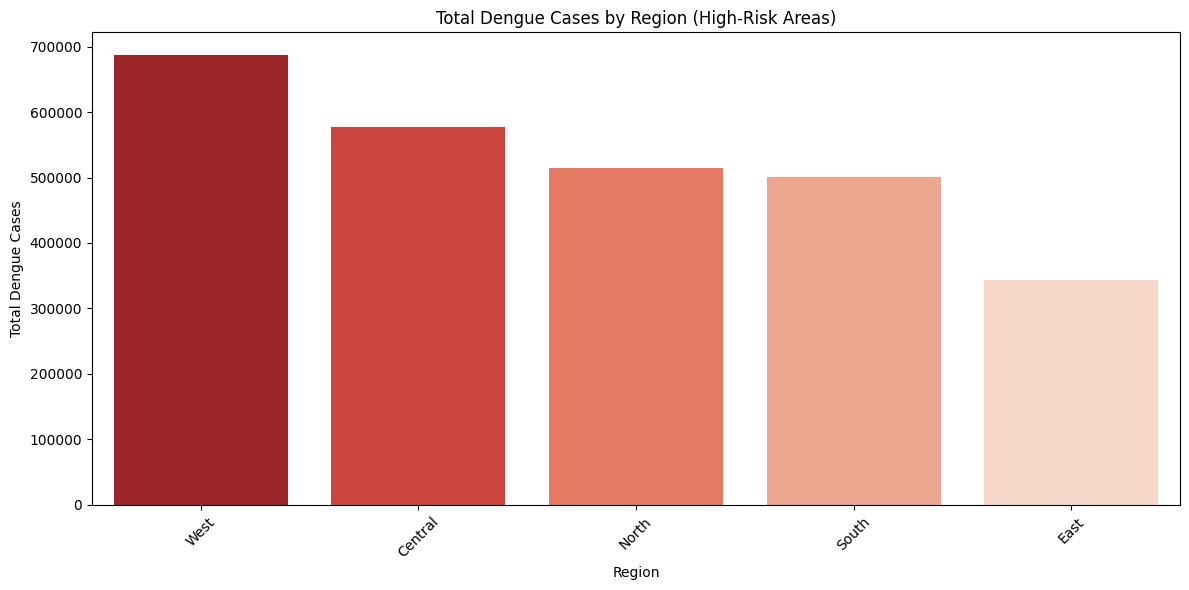

In [ ]:
area_cases = df.groupby('region')['dengue_cases'].sum().sort_values(ascending=False).reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=area_cases, x='region', y='dengue_cases', palette='Reds_r')
plt.title('Total Dengue Cases by Region (High-Risk Areas)')
plt.ylabel('Total Dengue Cases')
plt.xlabel('Region')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
finland_cases = df[df['country'] == 'Finland']['dengue_cases'].sum()
print("Total dengue cases in Finland:", finland_cases)

Total dengue cases in Finland: 21249


In [ ]:
top_regions = df.groupby('country')['dengue_cases'].sum().sort_values(ascending=False).head(5)
print("Top 5 regions with highest dengue cases:")
print(top_regions)

Top 5 regions with highest dengue cases:
country
Mauritania          31134
Marshall Islands    30296
Chile               29535
Tonga               29493
Netherlands         29293
Name: dengue_cases, dtype: int64


/tmp/ipython-input-64-2916480670.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_cases, x='month', y='dengue_cases', palette='Oranges_r')


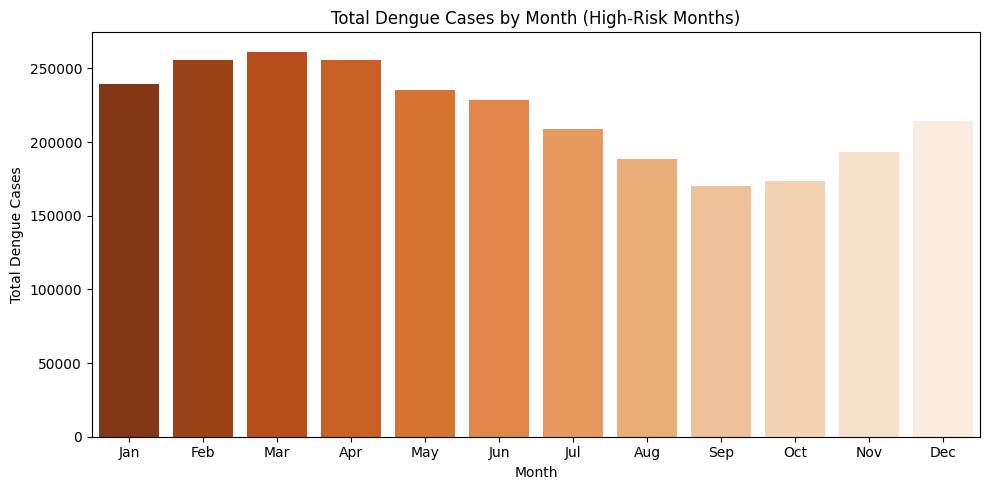

In [ ]:
monthly_cases = df.groupby('month')['dengue_cases'].sum().sort_values(ascending=False).reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=monthly_cases, x='month', y='dengue_cases', palette='Oranges_r')
plt.title('Total Dengue Cases by Month (High-Risk Months)')
plt.xlabel('Month')
plt.ylabel('Total Dengue Cases')
plt.xticks(ticks=range(0,12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()


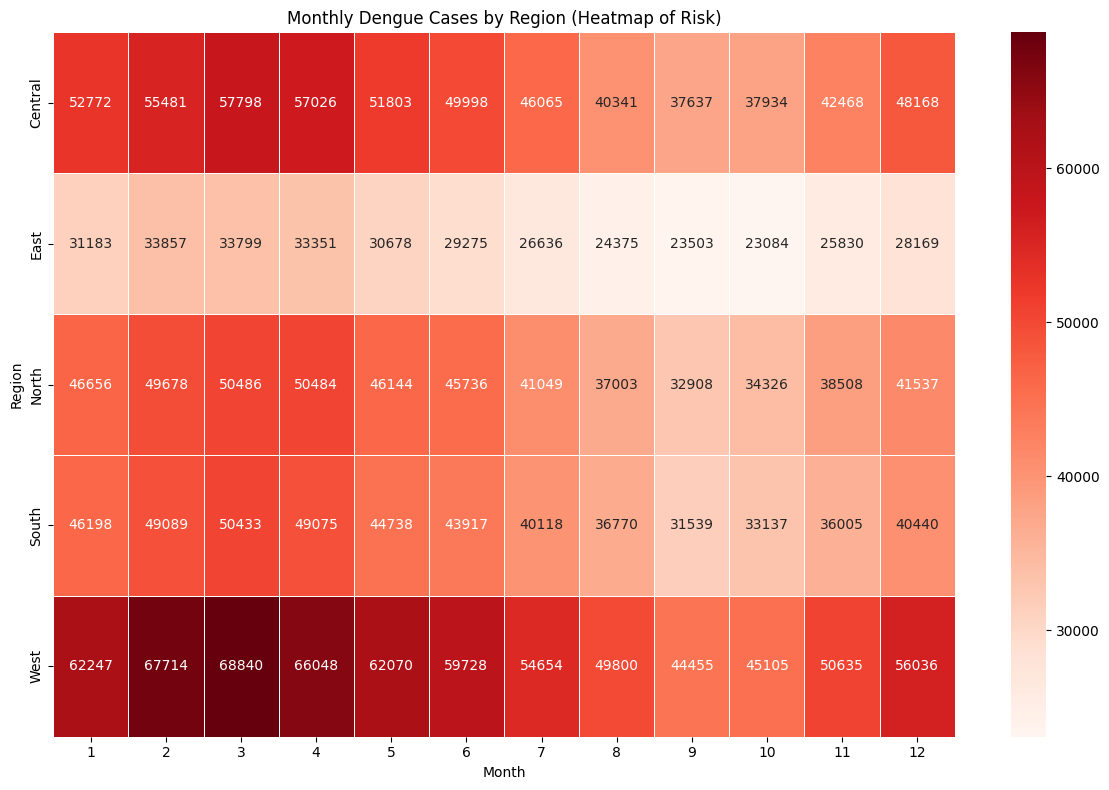

In [ ]:
heatmap_data = df.groupby(['region', 'month'])['dengue_cases'].sum().unstack()


plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='Reds', annot=True, fmt=".0f", linewidths=0.5)
plt.title('Monthly Dengue Cases by Region (Heatmap of Risk)')
plt.xlabel('Month')
plt.ylabel('Region')
plt.tight_layout()
plt.show()

### **ALIGN WITH METEOROLOGICAL DATA**

In [ ]:
agg_df = df.groupby(['region', 'month']).agg({
    'dengue_cases': 'sum',
    'avg_temp_c': 'mean',
    'precipitation_mm': 'mean',
    'uv_index': 'mean',
    'air_quality_index': 'mean'
}).reset_index()

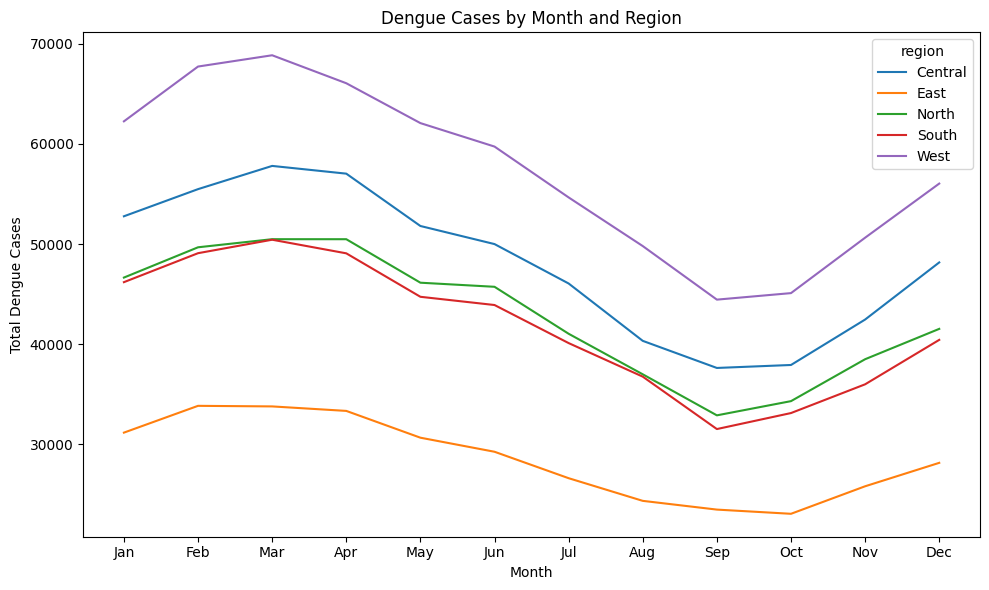

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=agg_df, x='month', y='dengue_cases', hue='region', palette='tab10')
plt.title('Dengue Cases by Month and Region')
plt.xlabel('Month')
plt.ylabel('Total Dengue Cases')
plt.xticks(ticks=range(1,13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()


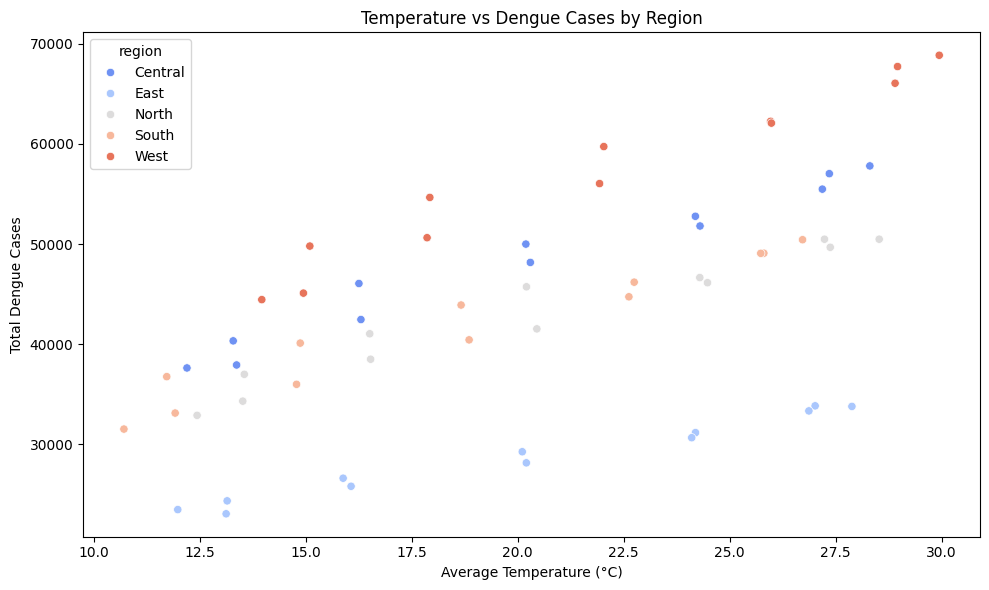

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=agg_df, x='avg_temp_c', y='dengue_cases', hue='region', palette='coolwarm')
plt.title('Temperature vs Dengue Cases by Region')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Total Dengue Cases')
plt.tight_layout()
plt.show()

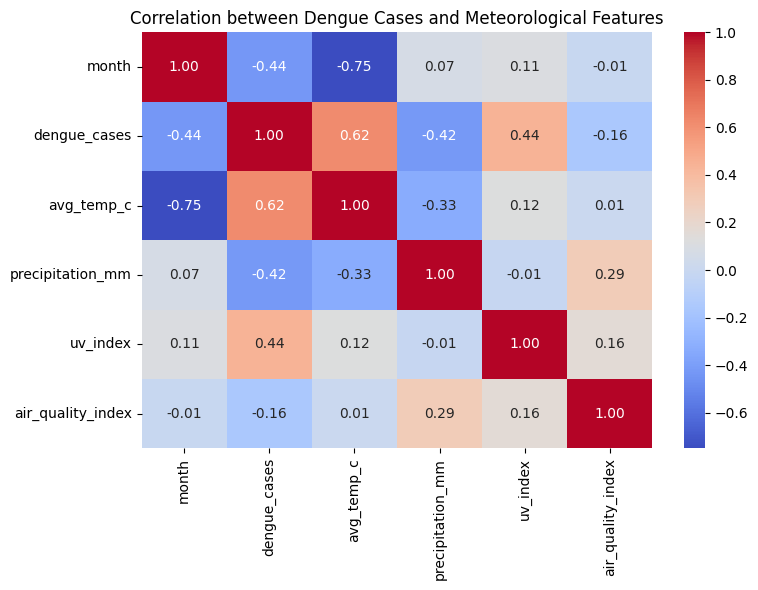

In [ ]:
corr = agg_df.drop(columns=['region']).corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between Dengue Cases and Meteorological Features')
plt.tight_layout()
plt.show()


### **REGRESSION FOR EACH REGION**

In [ ]:
regions = df['region'].unique()

for region in regions:
    region_df = df[df['region'] == region]

    # Define features and target
    X = region_df[['avg_temp_c', 'precipitation_mm', 'uv_index']]
    y = region_df['dengue_cases']

    # Drop rows with missing values
    X = X.dropna()
    y = y.loc[X.index]

    # Add constant term for intercept
    X = sm.add_constant(X)

    # Fit model
    model = sm.OLS(y, X).fit()

    # Display summary
    print(f"\n=== Region: {region} ===")
    print(model.summary())


=== Region: Central ===
                            OLS Regression Results                            
Dep. Variable:           dengue_cases   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     891.9
Date:                Mon, 14 Jul 2025   Prob (F-statistic):               0.00
Time:                        14:38:49   Log-Likelihood:                -37996.
No. Observations:                7776   AIC:                         7.600e+04
Df Residuals:                    7772   BIC:                         7.603e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const          